#### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

#################
# My notebook issues
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
sys.path.append('home/egupta/.local/bin')

##############

import os
import numpy as np
import scipy.stats as ss
import networkx as nx
import csv 
import numpy as np
import seaborn as sns
from pandas import DataFrame
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline


##qtensor imports
import qtensor
from qtensor import QAOA_energy
from qtensor import parameter_optimization as popt
import torch

2021-07-02 08:09:37,618- WARNING•	QuickBB solver is unavailable
2021-07-02 08:09:37,620- WARNING•	Tamaki solver is unavailable: No path /home/egupta/.local/lib/python3.7/site-packages/thirdparty/tamaki_treewidth


# Data Collection Details

y = 5

x = 11*y

Use data stored in drive to generate subgraph_similarity_metric vs actual similarity for random graphs

All random graphs have 20 nodes but they differ in how many even degree nodes they have. There are a total of x graphs-- y of them with 0 even nodes, y with 2 even degree nodes , ..., y with all 20 even degree nodes. (Generating 20-node graphs with say odd number of even degree nodes like 3 even degree nodes was not possible ---it raised networkx.exception.NXUnfeasible )

Also when I say y graphs with same even degree nodes, they also have same degree sequence. But they are different i.e. non-isomorphic/

** Now debugging why some graphs, having different parity have high tranferability **

# Tranferability Matrices for Subgraphs
one of them uses the averaging technique, the other uses the best of 20 trick

# Why Mutual Tranferability
In the tranferability paper, we saw patterns in how even and odd subgraphs tranfer. But there was an important claim underlying that blue colormap: all the subgraphs was mutually tranferable. Well, that fact is trvial, but not so in our case, where we are not comparing subgraphs but larger random graphs. 

I'm calling a graph odd based on the number of even degree nodes it has. But that does not mean, like an odd subgraph, it is mutually tranferable. Let me repeat: Odd subgraphs are mutually tranferable. But "odd" graphs are not necessarily so!

Now in the paper, there were 3 conditions for tranferability:
1. Donor graph is mutually transferable
2. Acceptor graph is mutually transferable
3. All subgraphs in donor graph are tranferable to all subgraphs in acceptor graph.

My **hypothesis** is that conditions #1 and #2 affect number #3. Specifically, I claim that mutual tranferability of donor and acceptor graphs affects how well we can predict similarity between the pair. (i.e. **how close subgraph similarity metric is to actualy similarity**)

# Transferability Matrix


In [2]:
def sub_all(d1, d2, draw=False):
    # returns a list of subgraphs of all graphs with nodes of the central edge having degree d1 and d2
    A = np.zeros((d1 + d2, d1 + d2))
    A[d1 + 1:, d1] = 1
    A[:d1 - 1, d1 - 1] = 1
    A[d1 - 1, :d1 - 1] = 1
    A[d1, d1 + 1:] = 1
    A[d1, d1 - 1] = 1
    A[d1 - 1, d1] = 1
    
    g = nx.from_numpy_matrix(np.array(A))

    g_list = [g]
    for i in range(min(d1, d2) - 1):
        g = g_list[i]
        g_list.append(nx.contracted_nodes(g, i, i + d1 + 1))
    # relabel center edge as (0, 1)
    for i, g in enumerate(g_list):
        g_list[i] = qtensor.tools.lightcone_orbits.relabel_edge_first(g, (d1 - 1, d1))
        if draw:
            nx.draw_kamada_kawai(g)
            plt.show()
    return g_list

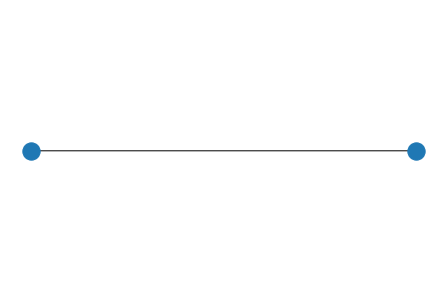

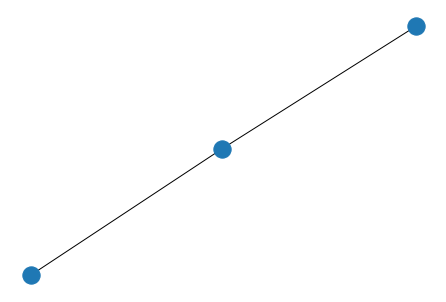

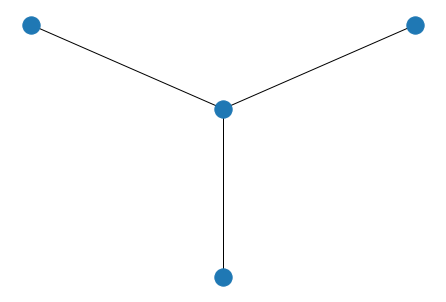

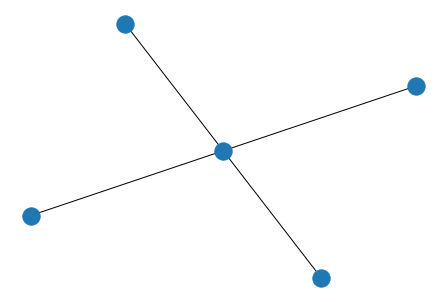

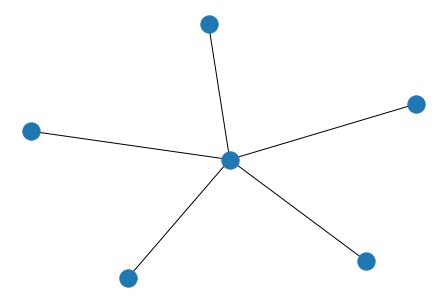

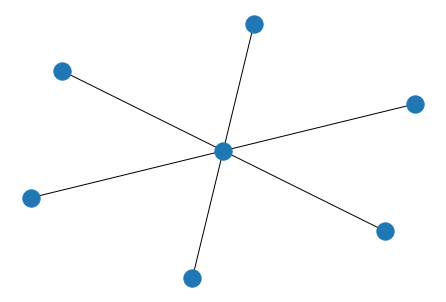

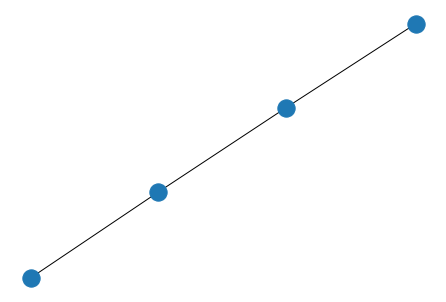

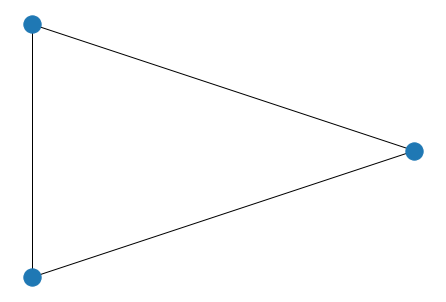

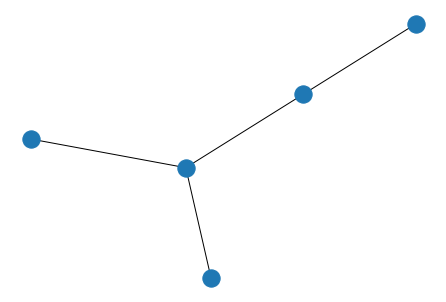

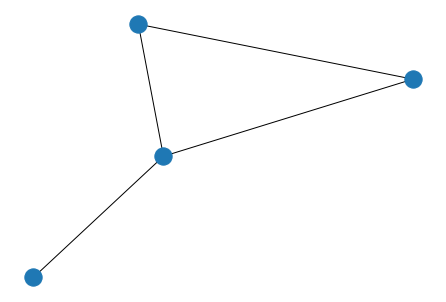

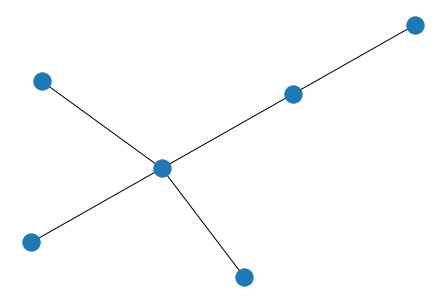

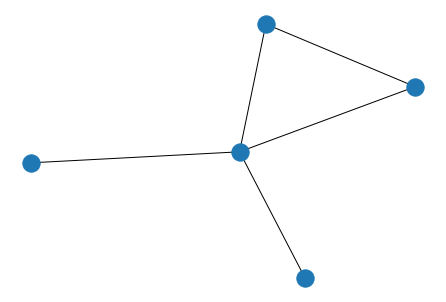

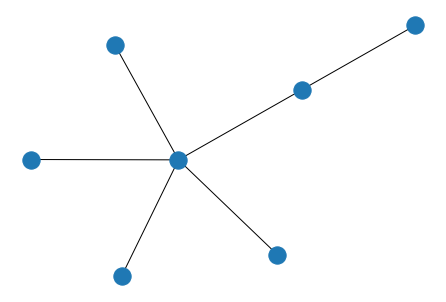

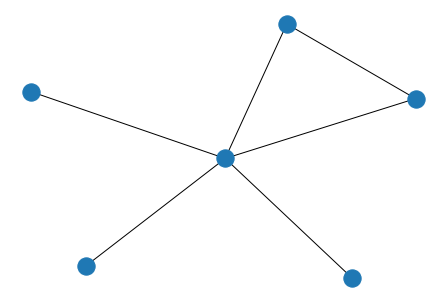

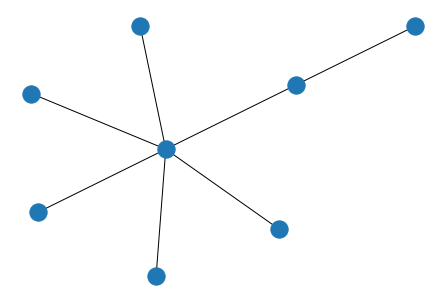

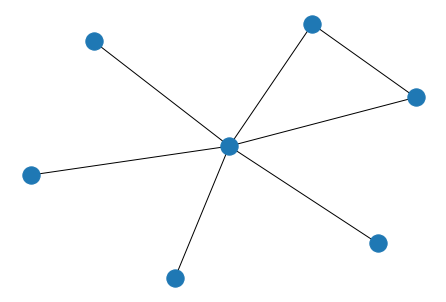

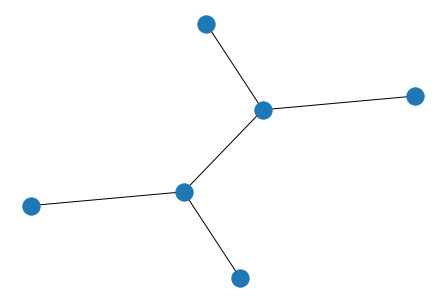

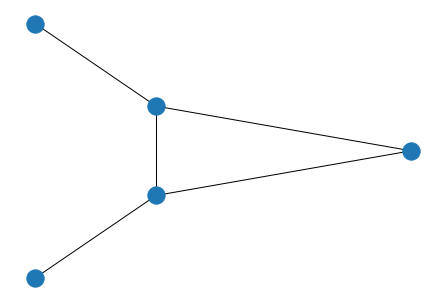

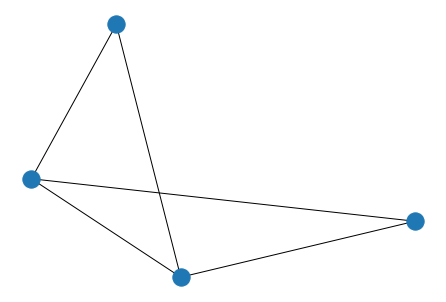

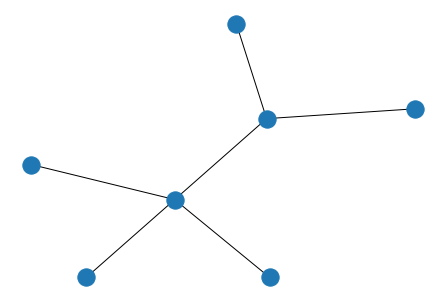

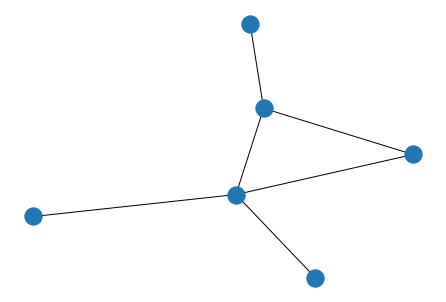

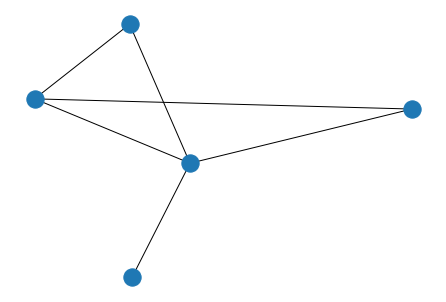

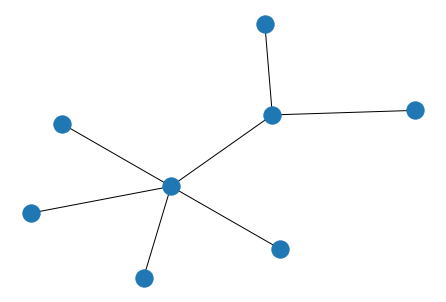

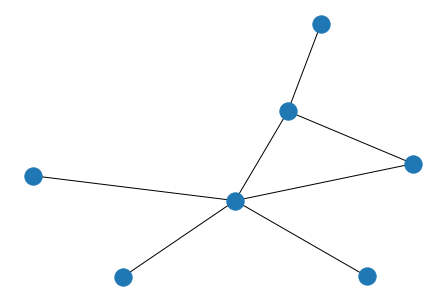

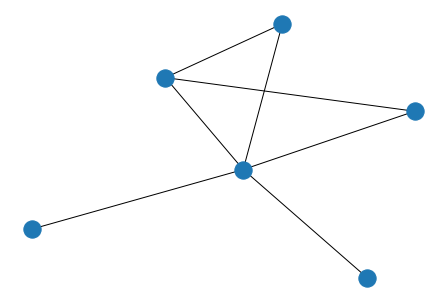

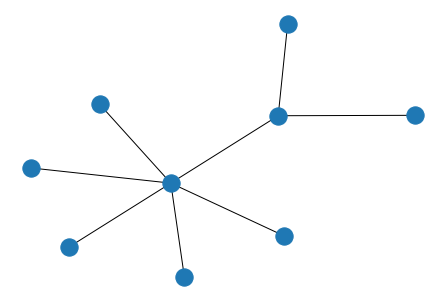

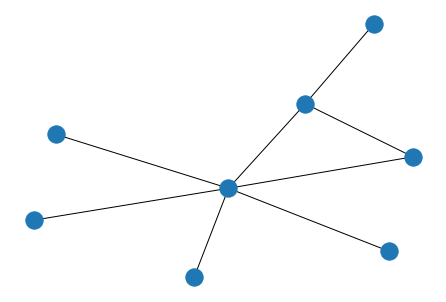

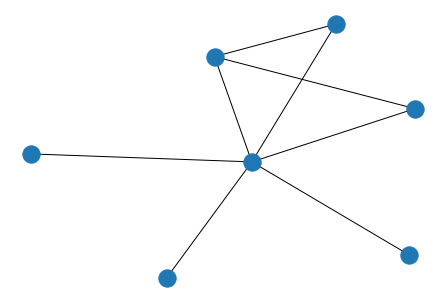

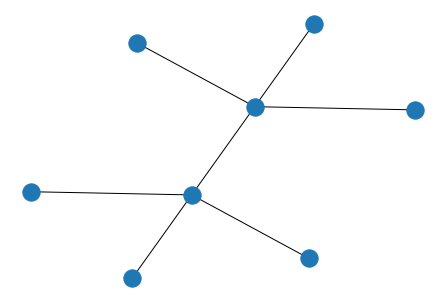

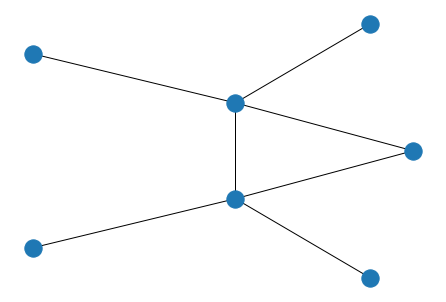

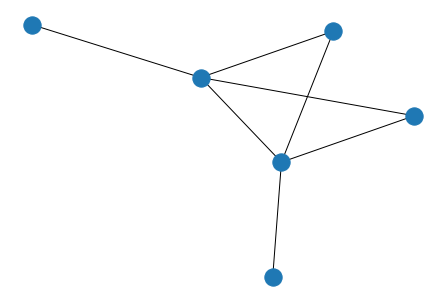

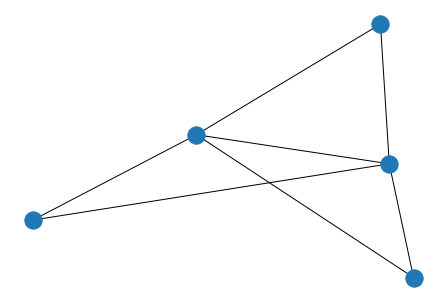

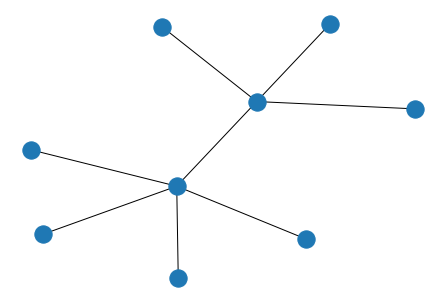

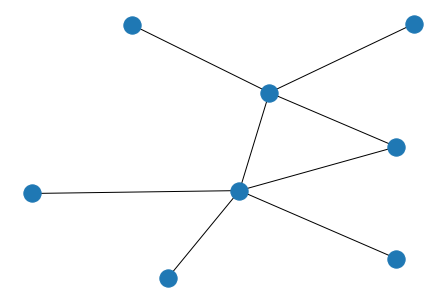

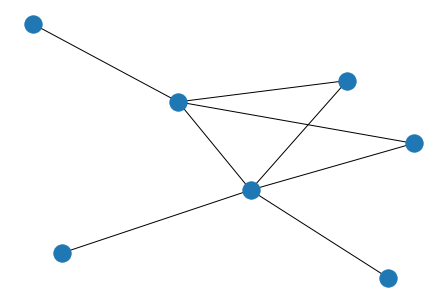

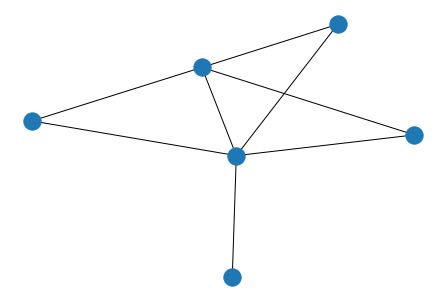

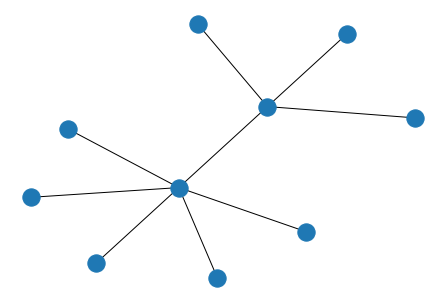

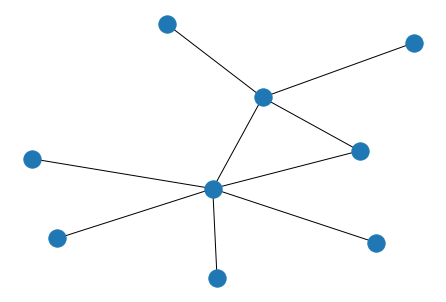

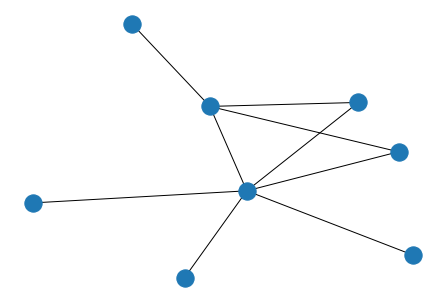

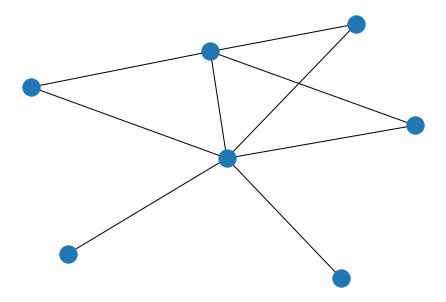

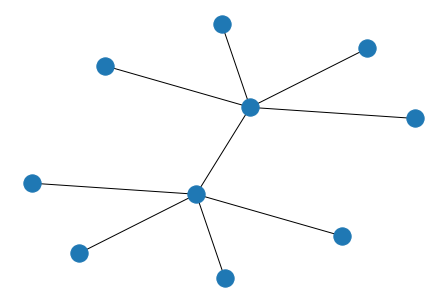

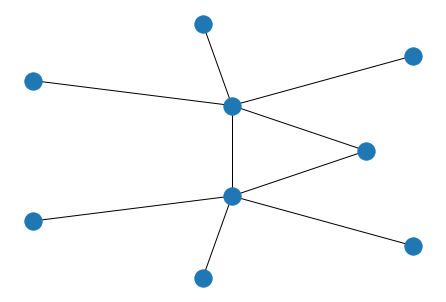

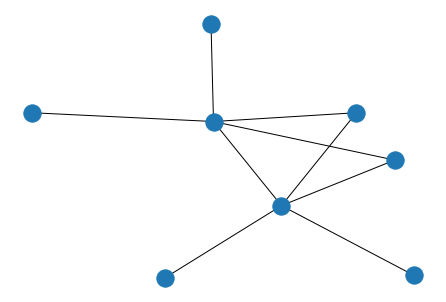

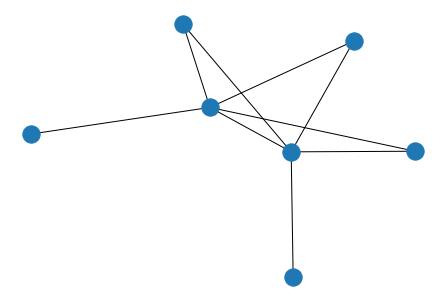

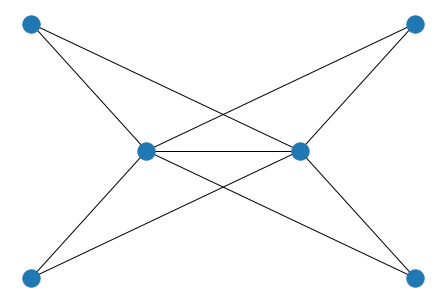

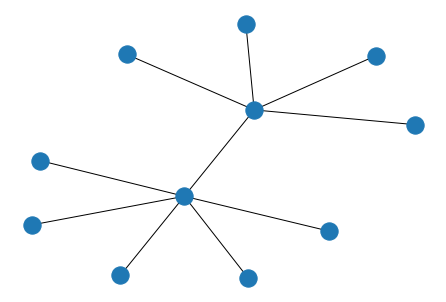

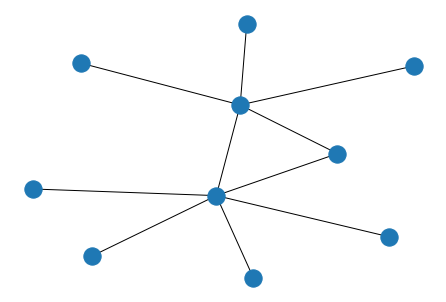

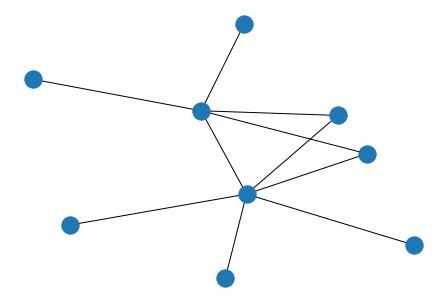

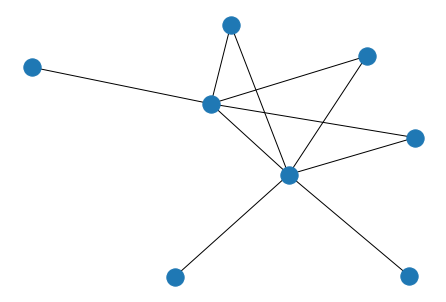

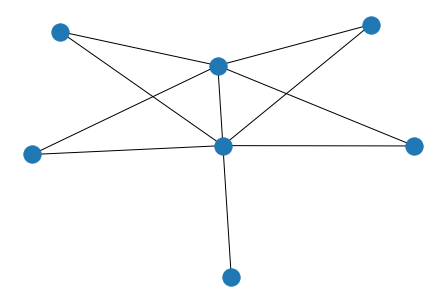

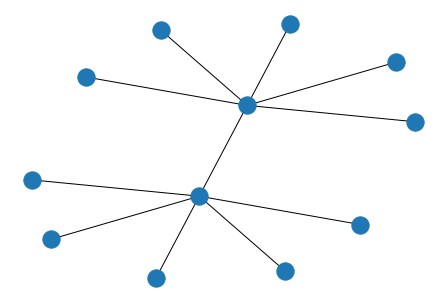

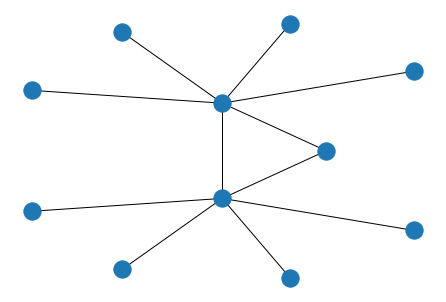

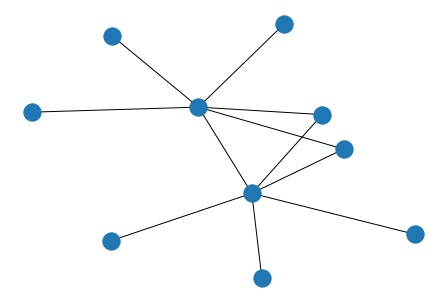

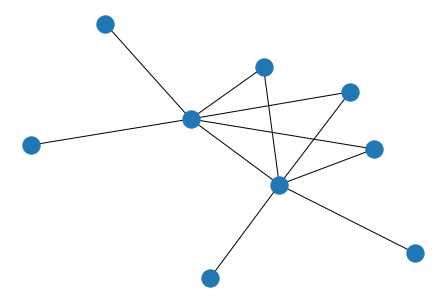

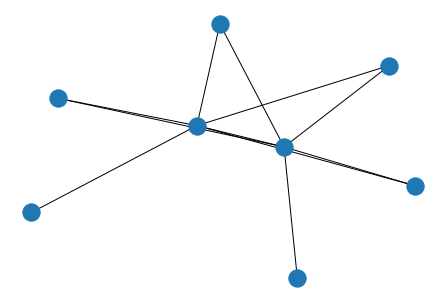

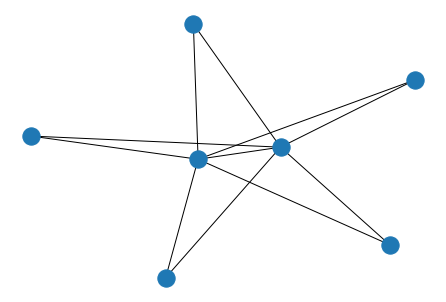

In [3]:
#generating all subgraphs first 
d_min = 1
d_max = 6
g_all = []
for i in range(d_min, d_max + 1):
    for j in range(i, d_max + 1):
        g_sub_ij = sub_all(i, j, draw=True)
        g_all += g_sub_ij

In [4]:
file1 = open("/home/egupta/Documents/Eesh's Experiments/Transferability Matrices/transferability_matrix_random_subgraphs_6.txt")
file2 = open("/home/egupta/Documents/Eesh's Experiments/Transferability Matrices/direct_transferability_matrix_random_subgraphs_6.txt")

In [5]:
tranf_mat_orig = np.loadtxt(file1).reshape(56,56)
tranf_mat_mod = np.loadtxt(file2).reshape(56,56)

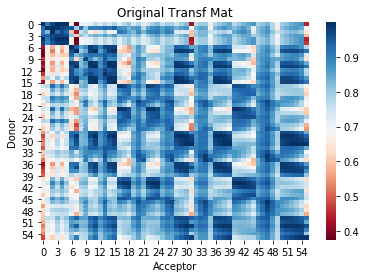

In [6]:
df = DataFrame(tranf_mat_orig)#, index=Index, columns=Cols)
sns.heatmap(df, annot=False, cmap="RdBu")
plt.title("Original Transf Mat")
plt.ylabel('Donor')
plt.xlabel('Acceptor')
plt.show()

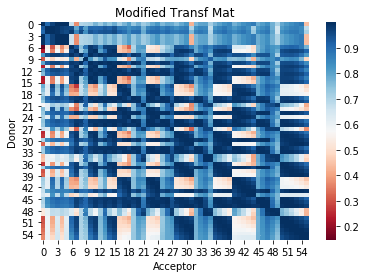

In [7]:
df = DataFrame(tranf_mat_mod)#, index=Index, columns=Cols)
sns.heatmap(df, annot=False, cmap="RdBu")
plt.title("Modified Transf Mat")
plt.ylabel('Donor')
plt.xlabel('Acceptor')
plt.show()

# Identifying subgraphs of a graph

In [8]:

def find_index(g, subgraphs):
    """
    finds index of subgraph g is isomorphic with
    """
    i = 0
    while i<len(subgraphs):
        if nx.is_isomorphic(g, subgraphs[i]):
            return i
        i+=1
    print('error: could not find subgraph')
    return -1
def find_subgraphs(G):
  '''
  Input: A graph G
  Output: A dictionary containg subgraphs and their frequency in G
  '''
  edges_done = []
  subgraphs = {}

  vertices = G.nodes
  for v1 in vertices:
    ######print('----------------------------------------')
    ######print('Parent checking for vertex ' +str(v1) )
    neighbors = nx.all_neighbors(G,v1)
    ######print(neighbors)
    #iterate over edges
    for v2 in neighbors:
      ######print('Childchecking for vertex ' +str(v2) )
      ##if already there
      if (v1,v2) in edges_done:
        #######print('Already looked at')
        continue
      ##add if not there
      else:
        ######print('Not looked at')
        edges_done.append((v1,v2))
        edges_done.append((v2,v1))
      
      neighbors1 = nx.all_neighbors(G,v1)
      neighbors2 = nx.all_neighbors(G, v2)

      subg_edge_set = []
      for v in neighbors1:
        #######print(v)
        edge = (v1, v)
        subg_edge_set.append(edge)

      for v in neighbors2:
        ######print(v)
        if v is not v1:
          edge = (v2, v)
          subg_edge_set.append(edge)

      ##creating the subgraph
      H = G.edge_subgraph(subg_edge_set)

      ##check if isomorphic with any other subgraphs
      iso = False
      subgraphs_arr = subgraphs.keys()
      for subgraph in subgraphs_arr:
        if nx.is_isomorphic(H, subgraph):
          #######print('is isomorphic')
          subgraphs[subgraph] +=1
          iso = True
          break
      if iso == False:
        #######print('---------------Adding a subgraph--------------------')
        subgraphs[H] = 1
        ######print(subgraphs)
  return subgraphs


# Similarity

In [13]:
def similarity(G1, G2, subgraphs, tranf_mat):
  """
  Compute similarity metric between 2 graphs
  """
  sub_g1_dict = find_subgraphs(G1)
  sub_g2_dict = find_subgraphs(G2)
  sub_g1 = sub_g1_dict.keys()
  sub_g2 = sub_g2_dict.keys()
  metric = 0
  total_arrows = 0

  for donor in sub_g1:
    for acceptor in sub_g2:
      arrows = sub_g1_dict[donor]*sub_g2_dict[acceptor]
      i = find_index(donor, subgraphs)
      j = find_index(acceptor, subgraphs)
      metric+= arrows*tranf_mat[i,j]
      total_arrows += arrows
  metric = metric/total_arrows
  return metric


##** Different from that in other notebooks **

from qtensor import QAOA_energy

def actual_sim(G1, G2,g1_results, g2_results):
  """
  Returns similarity between two graphs computed directly
  """
  #Now computing similarity
  sim = 0
  acc_max_energy = g2_results[2]
  donor_gamma = g1_results[0]
  donor_beta = g1_results[1]

  transf_energy = QAOA_energy(G2, [donor_gamma], [donor_beta])
  #print(transf_energy)
  sim = transf_energy/acc_max_energy
  return sim


def mutual_similarity(G1, subgraphs , tranf_mat):
  """
  Compute subgraph similarity metric within a graph
  """
  sub_g1_dict = find_subgraphs(G1)
  sub_g1 = sub_g1_dict.keys()
  metric = 0
  total_arrows = 0

  for donor in sub_g1:
    for acceptor in sub_g1:
      if (nx.is_isomorphic(donor, acceptor) is False):
        arrows = sub_g1_dict[donor]*sub_g1_dict[acceptor]
        i = find_index(donor, subgraphs)
        j = find_index(acceptor, subgraphs)
        metric+= arrows*tranf_mat[i,j]
        total_arrows += arrows
  metric = metric/total_arrows
  return metric


# Getting the graphs

In [15]:
g_data = []
with open('20NodeRandomData1.csv', 'r', newline = '') as s:
  spamreader = csv.reader(s, quotechar='|')
  for row in spamreader:
    new_row = [float(i) for i in row]
    g_data.append(new_row)

resi = []
with open('20NodeRandomGraph1.csv', 'r', newline = '') as g:
  spamreader = csv.reader(g, quotechar='|')
  for row in spamreader:
    resi.append(row)

#convert bunch of rows to matrices
n = int(len(resi)/20)
mat_list = []
for i in range(n):
  array = []
  for j in range(20):
    row = resi[i*20 +j]
    row = [float(k) for k in row]
    array.append(row)
  mat_list.append(array)

def mats_to_graphs(mat_list):
  """
  Given list of adjaceny matrix repr of graphs, converts to actual graphs
  """
  g_list = []
  for mat in mat_list:
    arr = np.array(mat)
    G = nx.convert_matrix.from_numpy_matrix(arr)
    g_list.append(G)
  return g_list

g_list = mats_to_graphs(mat_list)

In [16]:
len(g_list)

55

In [17]:
len(g_data)

55

In [29]:
#sanity check whether graphs are isomorphic
for i in range(len(g_list)):
    g1 = g_list[i]
    for j in range(len(g_list)):
        if i!=j:
            g2 = g_list[j]
            if nx.is_isomorphic(g1,g2):
                print('####')
                print(i)
                print(j)

# Testing median angle theory

In [21]:
i = 34
j = 2
g1 = g_list[i]
g2 = g_list[j]
g1_results = g_data[i]
g2_results = g_data[j]
actual_sim(g1,g2,g1_results, g2_results)

array([0.99913842])

In [22]:
for k in range(len(g_data)):
    g2 = g_list[k]
    g2_results = g_data[k]
    print(actual_sim(g1,g2,g1_results, g2_results))


[0.99966884]



[0.99999001]



[0.99913842]



[0.99933156]



[0.99949724]



[0.99947559]



[0.99843919]



[0.99834528]



[0.99962789]



[0.99945154]



[0.99591095]



[0.99621796]



[0.99926636]



[0.99872496]



[0.99765436]



[0.99840027]



[0.99931725]



[0.99934434]



[0.9924104]



[0.99547162]



[0.99409095]



[0.99423372]



[0.99981113]



[0.99998491]



[0.9999313]



[0.99934351]



[0.99943748]



[0.99849898]



[0.99895348]



[0.99721707]



[0.99919304]



[0.99857283]



[0.99826375]



[0.99871636]



[1.]



[0.99992277]



[0.99996822]



[0.99701671]



[0.99512606]



[0.99846377]



[0.99959878]



[0.99963037]



[0.9996052]



[0.99641947]



[0.99559584]



[0.99320271]



[0.9991449]



[0.99930146]



[0.99966809]



[0.99469577]



[0.99474118]



[0.99538153]



[0.99386005]



[0.99356057]



[0.9940912]


In [23]:
g_data[34]

[0.911597490310669, 0.6208335757255554, 21.160546969449502, 20.50595430138489]

In [24]:
g_data[17]

[0.9156420826911926, 0.11753447353839874, 21.965744686872064, nan]

In [30]:
graphs_maxxed = []
for i in range(len(g_list)):
    print('####################################')
    g1 = g_list[i]
    g1_results = g_data[i]
    g_maxxed = 0
    for k in range(len(g_data)):
        g2 = g_list[k]
        g2_results = g_data[k]
        sim = actual_sim(g1,g2,g1_results, g2_results)
        print(sim)
        if sim>0.95:
            g_maxxed+=1
    graphs_maxxed.append(g_maxxed)
        

####################################



[1.]



[0.99967582]



[0.99828077]



[0.99909269]



[0.99998229]



[0.99997803]



[0.99866432]



[0.99886003]



[0.99966144]



[0.99983019]



[0.99674298]



[0.99716669]



[0.99926487]



[0.9992387]



[0.99868035]



[0.99900539]



[0.99992334]



[0.99975154]



[0.99439428]



[0.99649746]



[0.99531817]



[0.9951649]



[0.9999291]



[0.99951842]



[0.9998761]



[0.99912984]



[0.99873531]



[0.99921652]



[0.99926381]



[0.99866147]



[0.99923891]



[0.99910568]



[0.99891782]



[0.99929712]



[0.99967527]



[0.99991098]



[0.99979387]



[0.99822427]



[0.9969908]



[0.9986811]



[0.9996568]



[0.99965451]



[0.99978711]



[0.99701336]



[0.99669528]



[0.99514891]



[0.99942146]



[0.99981073]



[0.99987877]



[0.99551134]



[0.99622217]



[0.99624643]



[0.99553404]



[0.9949671]



[0.99539153]
####################################



[0.99966933]



[1.]



[0.94958169]



[0.95827142]



[0.91742859]



[0.90296319]



[0.85458314]



[0.8516048]



[0.78900892]



[0.79794762]



[0.78606628]



[0.79226831]



[0.69775824]



[0.70255551]



[0.65501343]



[0.65357148]



[0.58278598]



[0.59192793]



[0.5823343]



[0.58185664]



[0.54620827]



[0.54924326]



[0.99984773]



[0.9999706]



[0.99994781]



[0.94920367]



[0.94974043]



[0.95857769]



[0.68804132]



[0.70952037]



[0.69323546]



[0.65364162]



[0.65686368]



[0.66041256]



[0.89278379]



[0.89981351]



[0.90676559]



[0.86890772]



[0.86783306]



[0.85878566]



[0.7878855]



[0.79310014]



[0.79255208]



[0.7889985]



[0.79132565]



[0.80312839]



[0.58818204]



[0.58560463]



[0.58792853]



[0.58990582]



[0.5774894]



[0.58340048]



[0.54130865]



[0.54444909]



[0.54544298]
####################################



[0.99814666]



[0.99919918]



[1.]



[0.99970909]



[0.99787498]



[0.99783787]



[0.99499664]



[0.99491034]



[0.99745879]



[0.99726584]



[0.9909879]



[0.99160358]



[0.99661666]



[0.99560543]



[0.9942569]



[0.9952343]



[0.99794643]



[0.99712887]



[0.98686809]



[0.99057819]



[0.98870159]



[0.98866461]



[0.99884859]



[0.99910944]



[0.99894786]



[0.99968567]



[0.99996278]



[0.99814594]



[0.9959883]



[0.99403528]



[0.99645312]



[0.99550974]



[0.995004]



[0.99587855]



[0.99902867]



[0.99863771]



[0.99864891]



[0.99310007]



[0.99080849]



[0.99504593]



[0.997386]



[0.99745635]



[0.99748846]



[0.99172356]



[0.99069102]



[0.98786957]



[0.99647998]



[0.99719385]



[0.99788558]



[0.9891635]



[0.98990588]



[0.99030778]



[0.98891632]



[0.98804362]



[0.98876059]
####################################



[0.99895867]



[0.99939446]



[0.99970777]



[1.]



[0.99881549]



[0.99879349]



[0.99556568]



[0.99574615]



[0.99791447]



[0.99803823]



[0.99204592]



[0.99276257]



[0.99699895]



[0.99647224]



[0.99554574]



[0.99613176]



[0.99889085]



[0.99790147]



[0.98895576]



[0.99177339]



[0.99005071]



[0.98974631]



[0.99944652]



[0.99916789]



[0.999387]



[0.99999954]



[0.99982122]



[0.99933631]



[0.99666254]



[0.99576397]



[0.9968803]



[0.99634117]



[0.99594789]



[0.99674961]



[0.99920765]



[0.99911222]



[0.99897502]



[0.99458066]



[0.99290046]



[0.99560694]



[0.99786459]



[0.99790473]



[0.99807846]



[0.99255827]



[0.99199276]



[0.98995942]



[0.99714328]



[0.99805928]



[0.99846767]



[0.99017884]



[0.99152137]



[0.99135787]



[0.99067671]



[0.98956067]



[0.99017806]
####################################



[0.99998159]



[0.99951004]



[0.99798707]



[0.99894034]



[1.]



[0.99999976]



[0.9986354]



[0.99889738]



[0.99958188]



[0.99982962]



[0.99686075]



[0.99731115]



[0.99918122]



[0.99927295]



[0.99883592]



[0.99906458]



[0.99997682]



[0.99975973]



[0.99477923]



[0.99666279]



[0.99553277]



[0.99531166]



[0.9998621]



[0.99931776]



[0.99976949]



[0.99898328]



[0.99847713]



[0.99928278]



[0.99925157]



[0.99890861]



[0.99916612]



[0.99914825]



[0.99898824]



[0.99935063]



[0.99950785]



[0.99981509]



[0.99966081]



[0.99842032]



[0.9973374]



[0.99865041]



[0.99958286]



[0.99957276]



[0.99974153]



[0.99707656]



[0.99687434]



[0.99552195]



[0.99939975]



[0.99984224]



[0.99984199]



[0.99562857]



[0.99649168]



[0.99637495]



[0.99585068]



[0.99522278]



[0.99562281]
####################################



[0.99997718]



[0.99948796]



[0.99794479]



[0.99891412]



[0.99999975]



[1.]



[0.99864066]



[0.99890913]



[0.99957539]



[0.99983103]



[0.99688828]



[0.99733993]



[0.99917704]



[0.99928248]



[0.99885959]



[0.99907769]



[0.99998041]



[0.99976277]



[0.99483646]



[0.99669542]



[0.99557302]



[0.99534601]



[0.99985052]



[0.99929258]



[0.99975409]



[0.99895781]



[0.99843985]



[0.99928135]



[0.99925588]



[0.99893935]



[0.99916342]



[0.9991592]



[0.99900289]



[0.99936165]



[0.99948645]



[0.99980215]



[0.99964433]



[0.99844994]



[0.99738372]



[0.99865538]



[0.99957713]



[0.99956605]



[0.99973818]



[0.99709768]



[0.99690788]



[0.99557652]



[0.99940181]



[0.99984708]



[0.99983868]



[0.99565931]



[0.99653425]



[0.99640477]



[0.99589877]



[0.99526765]



[0.99566439]
####################################



[0.99878513]



[0.99831167]



[0.99568789]



[0.99644204]



[0.99875464]



[0.99876115]



[1.]



[0.9999155]



[0.99959949]



[0.9994796]



[0.99933671]



[0.99931292]



[0.99984685]



[0.99985121]



[0.99936321]



[0.99982075]



[0.99862964]



[0.99961367]



[0.99671094]



[0.99898693]



[0.9982774]



[0.99859183]



[0.99834928]



[0.99837144]



[0.99847463]



[0.9965028]



[0.99636366]



[0.99646801]



[0.99991418]



[0.9984481]



[0.99988025]



[0.99985435]



[0.99979483]



[0.99975383]



[0.9984977]



[0.99878213]



[0.99884575]



[0.99918395]



[0.99779127]



[0.99999992]



[0.99962406]



[0.99959618]



[0.99954129]



[0.99957782]



[0.99903379]



[0.99715836]



[0.99988003]



[0.99945208]



[0.99945531]



[0.99889675]



[0.99819538]



[0.99909203]



[0.99750084]



[0.99789386]



[0.99819752]
####################################



[0.99892716]



[0.998158]



[0.99537549]



[0.99643571]



[0.99897998]



[0.99899425]



[0.99991367]



[1.]



[0.99952236]



[0.99960171]



[0.99946432]



[0.99954502]



[0.99971066]



[0.99996261]



[0.99974484]



[0.99998291]



[0.99897472]



[0.99974152]



[0.9974518]



[0.99924131]



[0.99860127]



[0.99872107]



[0.99842846]



[0.99811998]



[0.99845049]



[0.99650657]



[0.99610324]



[0.9969362]



[0.99992325]



[0.99909927]



[0.99976106]



[0.9999874]



[0.99997453]



[0.9999412]



[0.9983244]



[0.99875566]



[0.99872076]



[0.99961725]



[0.99856235]



[0.99991171]



[0.99955593]



[0.99951361]



[0.99955639]



[0.9995922]



[0.99931967]



[0.99789193]



[0.99988028]



[0.99965267]



[0.99951799]



[0.99895318]



[0.99872558]



[0.99923035]



[0.99814451]



[0.99830854]



[0.99857246]
####################################



[0.9996773]



[0.99953149]



[0.99774294]



[0.99828155]



[0.99959021]



[0.99958303]



[0.99958546]



[0.99952955]



[1.]



[0.99988886]



[0.9980104]



[0.99816991]



[0.99992112]



[0.99970502]



[0.99894558]



[0.99950362]



[0.9994101]



[0.99987431]



[0.99505303]



[0.99762342]



[0.9965785]



[0.99677148]



[0.99950764]



[0.99954265]



[0.99961124]



[0.99831913]



[0.99824357]



[0.99797729]



[0.9998274]



[0.99835805]



[0.99990458]



[0.99960298]



[0.99942597]



[0.99963327]



[0.99962925]



[0.9997644]



[0.99980109]



[0.99856832]



[0.99699358]



[0.99959675]



[0.99999933]



[0.99999991]



[0.99997557]



[0.9983618]



[0.99773015]



[0.99568737]



[0.99988882]



[0.99978633]



[0.99994017]



[0.99715699]



[0.99691913]



[0.99760872]



[0.99614477]



[0.99614078]



[0.99655086]
####################################



[0.99983251]



[0.99935457]



[0.99739909]



[0.99828036]



[0.99983456]



[0.99983611]



[0.99944823]



[0.99958172]



[0.99988988]



[1.]



[0.99809154]



[0.99836519]



[0.99973382]



[0.99979483]



[0.99932618]



[0.99963959]



[0.9997615]



[0.99998922]



[0.99580688]



[0.99783476]



[0.99685954]



[0.99683791]



[0.99959026]



[0.99925751]



[0.99957918]



[0.99832938]



[0.99795925]



[0.99850728]



[0.99980295]



[0.99904693]



[0.99973662]



[0.99970605]



[0.99958188]



[0.99979538]



[0.99942746]



[0.99972733]



[0.99965475]



[0.99900994]



[0.99781203]



[0.99945732]



[0.99989944]



[0.99988376]



[0.99996758]



[0.99831625]



[0.99798662]



[0.99644226]



[0.99986445]



[0.99998138]



[0.9999805]



[0.99715247]



[0.99743565]



[0.99769247]



[0.99677733]



[0.99652306]



[0.99688807]
####################################



[0.99701973]



[0.99577297]



[0.99207867]



[0.99352087]



[0.99718349]



[0.99721829]



[0.99933101]



[0.99948482]



[0.99805479]



[0.99824148]



[1.]



[0.99995742]



[0.99857516]



[0.99918379]



[0.99947572]



[0.99948877]



[0.99743149]



[0.99860522]



[0.99871169]



[0.9999313]



[0.99970953]



[0.99983849]



[0.99623481]



[0.9957237]



[0.99621881]



[0.99362253]



[0.99300825]



[0.99461324]



[0.99903288]



[0.9985619]



[0.99868599]



[0.99940554]



[0.99954293]



[0.99926004]



[0.99601304]



[0.99667367]



[0.99660796]



[0.99953222]



[0.99885241]



[0.99931759]



[0.99811954]



[0.99803686]



[0.99811035]



[0.9999536]



[0.99992601]



[0.99891403]



[0.99891732]



[0.99848201]



[0.99812407]



[0.99990542]



[0.99947643]



[0.9999763]



[0.99906704]



[0.99952061]



[0.99965154]
####################################



[0.997243]



[0.99586211]



[0.99216643]



[0.99376096]



[0.99744966]



[0.99748687]



[0.99927126]



[0.99952862]



[0.99809605]



[0.99839965]



[0.99995858]



[1.]



[0.99854567]



[0.99927195]



[0.99968422]



[0.99958156]



[0.99776144]



[0.99874137]



[0.99898936]



[0.99996083]



[0.99973902]



[0.99973904]



[0.99645235]



[0.99575044]



[0.99637355]



[0.99386529]



[0.99310468]



[0.99508961]



[0.99906776]



[0.99897393]



[0.99866002]



[0.99949044]



[0.99963934]



[0.99939298]



[0.99608271]



[0.99681073]



[0.99668448]



[0.99975071]



[0.99924539]



[0.99925801]



[0.99816274]



[0.99807581]



[0.99820919]



[0.99985969]



[0.99997948]



[0.99920955]



[0.99894836]



[0.9986702]



[0.99824972]



[0.99977217]



[0.99967979]



[0.99992253]



[0.99933083]



[0.99959682]



[0.99971846]
####################################



[0.99932049]



[0.99914863]



[0.99707322]



[0.9975876]



[0.99922647]



[0.99922169]



[0.99984344]



[0.99971386]



[0.99992405]



[0.99973637]



[0.99856037]



[0.99860789]



[1.]



[0.99978295]



[0.99903045]



[0.99962795]



[0.99902239]



[0.99977414]



[0.99551338]



[0.99814202]



[0.99720675]



[0.99751966]



[0.99906476]



[0.99921559]



[0.99921498]



[0.9976306]



[0.99762569]



[0.99724387]



[0.99991803]



[0.99821761]



[0.99999729]



[0.99971202]



[0.99956466]



[0.99966972]



[0.99929099]



[0.99943302]



[0.99951675]



[0.9987178]



[0.99709324]



[0.99985073]



[0.99993018]



[0.99992497]



[0.99985204]



[0.99890851]



[0.99821299]



[0.99607534]



[0.99993735]



[0.99963019]



[0.99977301]



[0.99789945]



[0.99730314]



[0.9982176]



[0.99652125]



[0.99675806]



[0.99714013]
####################################



[0.99927861]



[0.99857291]



[0.99601403]



[0.99704259]



[0.99932193]



[0.99933278]



[0.99985093]



[0.99996159]



[0.99970275]



[0.99980308]



[0.99915067]



[0.99929327]



[0.999787]



[1.]



[0.99972085]



[0.99996681]



[0.9992965]



[0.99989387]



[0.997096]



[0.99892333]



[0.9981889]



[0.99825601]



[0.99884812]



[0.99851227]



[0.99885431]



[0.99710762]



[0.99669713]



[0.99749479]



[0.9999673]



[0.99920448]



[0.9998247]



[0.99998781]



[0.99994527]



[0.99998387]



[0.99871215]



[0.99911514]



[0.99906345]



[0.99954613]



[0.9984712]



[0.99985193]



[0.9997299]



[0.9996947]



[0.99975479]



[0.99929921]



[0.99902701]



[0.99759444]



[0.99994956]



[0.99983303]



[0.99972761]



[0.99850972]



[0.99845925]



[0.99886716]



[0.99786219]



[0.99788951]



[0.99818034]
####################################



[0.99855451]



[0.99724639]



[0.99408164]



[0.99568462]



[0.9987578]



[0.99878708]



[0.99937103]



[0.99974211]



[0.99886678]



[0.99928156]



[0.99942767]



[0.99966164]



[0.99901099]



[0.99970858]



[1.]



[0.99985455]



[0.99899597]



[0.99946258]



[0.99850719]



[0.99943662]



[0.99896896]



[0.99877505]



[0.99791732]



[0.99704922]



[0.99776767]



[0.99577559]



[0.99491882]



[0.99702688]



[0.99948936]



[0.99974918]



[0.99909647]



[0.9998011]



[0.99988242]



[0.99983006]



[0.99739267]



[0.99809029]



[0.99789241]



[0.99997795]



[0.99951715]



[0.99936453]



[0.9989188]



[0.99884822]



[0.99905242]



[0.99935018]



[0.99954785]



[0.99889786]



[0.99941742]



[0.99948707]



[0.99910087]



[0.99886176]



[0.99937544]



[0.99924489]



[0.99900743]



[0.99883656]



[0.99901939]
####################################



[0.99897737]



[0.99809073]



[0.99526753]



[0.99645341]



[0.99906443]



[0.99908155]



[0.99981963]



[0.99998125]



[0.99946036]



[0.99962659]



[0.99943206]



[0.99956454]



[0.99961185]



[0.99996388]



[0.99985391]



[1.]



[0.99910926]



[0.99976339]



[0.99767497]



[0.99926296]



[0.99864155]



[0.9986725]



[0.99846033]



[0.99800859]



[0.9984367]



[0.99652782]



[0.99601181]



[0.99714887]



[0.99988198]



[0.9993374]



[0.99966788]



[0.9999942]



[0.99999743]



[0.99997613]



[0.99824568]



[0.99873565]



[0.998657]



[0.99974221]



[0.99882795]



[0.99981724]



[0.99949695]



[0.99944941]



[0.99953561]



[0.99951449]



[0.99935698]



[0.99811833]



[0.99983804]



[0.99970876]



[0.99951923]



[0.99887574]



[0.99887039]



[0.99919733]



[0.99833618]



[0.99838649]



[0.99863686]
####################################



[0.99991511]



[0.99928453]



[0.99767231]



[0.99878723]



[0.99997482]



[0.9999788]



[0.99845196]



[0.9988006]



[0.99939881]



[0.99974818]



[0.99679159]



[0.99729118]



[0.99896692]



[0.99919022]



[0.99889113]



[0.99900533]



[1.]



[0.99968316]



[0.99502512]



[0.9966534]



[0.99556055]



[0.99524288]



[0.99975719]



[0.99904339]



[0.9996122]



[0.99883582]



[0.99819289]



[0.9993803]



[0.99911508]



[0.9991009]



[0.99896161]



[0.99907276]



[0.9989391]



[0.99929995]



[0.9992719]



[0.99965767]



[0.99945359]



[0.99850696]



[0.99760092]



[0.99846573]



[0.99940494]



[0.9993869]



[0.9996048]



[0.99694707]



[0.99688543]



[0.99576575]



[0.99926369]



[0.99980127]



[0.999727]



[0.99552671]



[0.99662138]



[0.99630897]



[0.99603451]



[0.99529821]



[0.9956756]
####################################



[0.99973549]



[0.99918939]



[0.99707738]



[0.99800677]



[0.99975067]



[0.99975469]



[0.99957508]



[0.99970933]



[0.99987336]



[0.99998833]



[0.99838631]



[0.9986314]



[0.99977348]



[0.9998815]



[0.99946661]



[0.99975516]



[0.9996894]



[1.]



[0.99618]



[0.99814006]



[0.99722557]



[0.99721871]



[0.99944361]



[0.99909791]



[0.99943302]



[0.99806004]



[0.99767]



[0.99830741]



[0.99987543]



[0.99914235]



[0.9997855]



[0.99980954]



[0.99970701]



[0.99987779]



[0.99927828]



[0.99960926]



[0.99953827]



[0.9991891]



[0.99803415]



[0.99958206]



[0.99988756]



[0.99986668]



[0.999948]



[0.99858793]



[0.9982825]



[0.99678276]



[0.9999154]



[0.99998185]



[0.99994971]



[0.99751694]



[0.99773556]



[0.99801466]



[0.99709592]



[0.99690176]



[0.9972471]
####################################



[0.99405821]



[0.99159184]



[0.98686925]



[0.98953074]



[0.99458463]



[0.99465635]



[0.9965758]



[0.99735462]



[0.99473669]



[0.99566524]



[0.99871927]



[0.99899121]



[0.99531848]



[0.99693901]



[0.99854295]



[0.99769366]



[0.99565199]



[0.9962427]



[1.]



[0.99927245]



[0.99957705]



[0.99902576]



[0.99294347]



[0.99119499]



[0.99255091]



[0.98968135]



[0.98806136]



[0.99251787]



[0.99638715]



[0.99830109]



[0.99551446]



[0.99746877]



[0.99783588]



[0.99747198]



[0.99181422]



[0.99308017]



[0.99265732]



[0.99880401]



[0.99946513]



[0.99655157]



[0.99484629]



[0.99469436]



[0.99512468]



[0.99820289]



[0.9992315]



[0.99996129]



[0.99617856]



[0.99635807]



[0.99542811]



[0.99866225]



[0.99980621]



[0.9989352]



[0.9999655]



[0.99974972]



[0.9996827]
####################################



[0.99655592]



[0.99500928]



[0.99106036]



[0.9928005]



[0.99680627]



[0.99685018]



[0.99890647]



[0.99921022]



[0.99749723]



[0.9978624]



[0.99992688]



[0.99995675]



[0.99802842]



[0.99888456]



[0.99948617]



[0.99929002]



[0.99723079]



[0.99827322]



[0.99925334]



[1.]



[0.99990282]



[0.99987045]



[0.99568666]



[0.99487714]



[0.99558032]



[0.99291436]



[0.99205646]



[0.99435545]



[0.99863603]



[0.99873916]



[0.99816062]



[0.99917162]



[0.99936626]



[0.99905961]



[0.99524498]



[0.99605417]



[0.99590289]



[0.99959891]



[0.99924472]



[0.99889024]



[0.99757321]



[0.99747339]



[0.99763223]



[0.99976556]



[0.99999342]



[0.99940303]



[0.99849921]



[0.99820618]



[0.99770783]



[0.99984018]



[0.99978128]



[0.99995518]



[0.99950231]



[0.99980172]



[0.99988331]
####################################



[0.49149316]



[0.49502325]



[0.53462719]



[0.53856688]



[0.62912915]



[0.61739549]



[0.69262727]



[0.6898767]



[0.74475706]



[0.75274815]



[0.78403398]



[0.78961795]



[0.84676939]



[0.8526501]



[0.89266046]



[0.88896951]



[0.93112251]



[0.93790695]



[0.96758899]



[0.96040117]



[1.]



[0.99988412]



[0.49174825]



[0.4965588]



[0.49335567]



[0.53131338]



[0.53460994]



[0.53397028]



[0.83936385]



[0.86365837]



[0.8429356]



[0.88857422]



[0.89252373]



[0.89526932]



[0.61056922]



[0.61555632]



[0.622112]



[0.70459459]



[0.70284584]



[0.69644013]



[0.74416854]



[0.74854185]



[0.74813633]



[0.78668408]



[0.7894281]



[0.8012253]



[0.9337677]



[0.93305841]



[0.93273295]



[0.96522069]



[0.95996833]



[0.96048362]



[0.99967289]



[0.99997203]



[0.99999173]
####################################



[0.48981287]



[0.49368539]



[0.53361556]



[0.53746322]



[0.62874906]



[0.61657429]



[0.69233889]



[0.68933347]



[0.7446694]



[0.75276471]



[0.78398098]



[0.78966209]



[0.84716304]



[0.8529973]



[0.89265676]



[0.88906429]



[0.93087644]



[0.93813645]



[0.96715291]



[0.96021747]



[0.99988306]



[1.]



[0.4901303]



[0.49534255]



[0.49186455]



[0.52993137]



[0.53354452]



[0.53235313]



[0.83933144]



[0.86386097]



[0.84317078]



[0.888686]



[0.89272742]



[0.89556341]



[0.60983443]



[0.6148809]



[0.62175658]



[0.70429506]



[0.70221702]



[0.69629183]



[0.74404825]



[0.74859644]



[0.74808357]



[0.7868305]



[0.78941911]



[0.80125207]



[0.93398931]



[0.93302953]



[0.93285552]



[0.9654634]



[0.95945789]



[0.96044206]



[0.99916424]



[0.99975261]



[0.99981231]
####################################



[0.99992668]



[0.99984993]



[0.94935731]



[0.95812449]



[0.91689169]



[0.90296702]



[0.85435565]



[0.85166964]



[0.78891731]



[0.79772802]



[0.78606517]



[0.79214868]



[0.69775126]



[0.70258879]



[0.6557162]



[0.65415154]



[0.58398793]



[0.59266108]



[0.58382205]



[0.58303617]



[0.54754898]



[0.55034243]



[1.]



[0.99970067]



[0.99997045]



[0.94940604]



[0.94959837]



[0.95899087]



[0.68851236]



[0.70975638]



[0.69340659]



[0.65419489]



[0.6573431]



[0.66076884]



[0.89268598]



[0.8996327]



[0.90622179]



[0.86870016]



[0.86798138]



[0.85840594]



[0.78784752]



[0.7928574]



[0.79242527]



[0.78879192]



[0.79128728]



[0.80305601]



[0.58896335]



[0.58661676]



[0.5887481]



[0.59064348]



[0.57901913]



[0.58443987]



[0.54303653]



[0.54591228]



[0.54684599]
####################################



[0.99951107]



[0.99997031]



[0.94961639]



[0.95826527]



[0.91757128]



[0.90292666]



[0.85460199]



[0.85151271]



[0.78893258]



[0.79791416]



[0.78595257]



[0.79219486]



[0.69764993]



[0.70241593]



[0.65461793]



[0.65322062]



[0.58201853]



[0.59141253]



[0.58132444]



[0.58096767]



[0.54525595]



[0.5484156]



[0.99969622]



[1.]



[0.99985534]



[0.94908865]



[0.94976366]



[0.95834767]



[0.68773602]



[0.70932485]



[0.69305454]



[0.65329569]



[0.65657183]



[0.66015177]



[0.89277312]



[0.89982605]



[0.90691962]



[0.8689314]



[0.86770513]



[0.85887057]



[0.78780245]



[0.79309229]



[0.79249394]



[0.78898438]



[0.79123749]



[0.80305943]



[0.58768632]



[0.58496393]



[0.58735072]



[0.58923654]



[0.5764344]



[0.5825898]



[0.54014222]



[0.54344993]



[0.54445697]
####################################



[0.99987467]



[0.99994847]



[0.94949314]



[0.9582221]



[0.91712616]



[0.90299504]



[0.85443574]



[0.85162948]



[0.78889232]



[0.79775224]



[0.7859934]



[0.79212277]



[0.6976563]



[0.70246699]



[0.65530211]



[0.65378712]



[0.58323271]



[0.59214585]



[0.58285728]



[0.58220186]



[0.54663337]



[0.54954753]



[0.99997032]



[0.99985678]



[1.]



[0.94937463]



[0.94971284]



[0.95885195]



[0.6882106]



[0.70956372]



[0.69323511]



[0.65383826]



[0.65703314]



[0.66049977]



[0.89274718]



[0.89972318]



[0.90646395]



[0.8687803]



[0.86790487]



[0.85855393]



[0.78780899]



[0.79290164]



[0.79241783]



[0.78881832]



[0.79123799]



[0.80302466]



[0.58845233]



[0.58597429]



[0.58817889]



[0.59002428]



[0.57801917]



[0.58367931]



[0.54191844]



[0.54494574]



[0.54589827]
####################################



[0.99899485]



[0.99940586]



[0.99968631]



[0.99999948]



[0.99885636]



[0.99883491]



[0.99561869]



[0.99580616]



[0.99794937]



[0.99808167]



[0.99212948]



[0.99284532]



[0.99703784]



[0.99652931]



[0.99561693]



[0.99618996]



[0.99892924]



[0.99794472]



[0.98907386]



[0.99186045]



[0.99014765]



[0.98983819]



[0.99947053]



[0.99917668]



[0.99940706]



[1.]



[0.99980755]



[0.99936789]



[0.9967127]



[0.9958447]



[0.99692138]



[0.99639651]



[0.99600836]



[0.99680346]



[0.99922095]



[0.99913691]



[0.9989962]



[0.99466316]



[0.9930037]



[0.99565945]



[0.99790058]



[0.99793952]



[0.99811628]



[0.99263333]



[0.99208255]



[0.99007503]



[0.99718878]



[0.9981038]



[0.99850095]



[0.99026836]



[0.99161904]



[0.99144309]



[0.99077982]



[0.98966354]



[0.99027621]
####################################



[0.99864993]



[0.99950456]



[0.99996237]



[0.99982058]



[0.99840833]



[0.99837495]



[0.9957823]



[0.99572458]



[0.99802334]



[0.99786769]



[0.99207114]



[0.99264491]



[0.99725066]



[0.99637462]



[0.99510688]



[0.99600113]



[0.9984181]



[0.99772435]



[0.98816583]



[0.99166517]



[0.98988437]



[0.98984887]



[0.99922854]



[0.99941521]



[0.99931406]



[0.9998053]



[1.]



[0.99848406]



[0.99670841]



[0.99491296]



[0.9971074]



[0.99625273]



[0.9957919]



[0.99658717]



[0.99936444]



[0.99906067]



[0.99906172]



[0.99406783]



[0.99191267]



[0.99582627]



[0.99796038]



[0.99802155]



[0.99805827]



[0.99274287]



[0.99179746]



[0.98913813]



[0.99714178]



[0.99778152]



[0.99838488]



[0.99034056]



[0.99103131]



[0.99140917]



[0.99007313]



[0.98926743]



[0.98994205]
####################################



[0.99909014]



[0.99862945]



[0.99820678]



[0.99934977]



[0.99914543]



[0.99914581]



[0.99545459]



[0.99602874]



[0.99758415]



[0.99817509]



[0.99271581]



[0.99358591]



[0.99659437]



[0.99677578]



[0.99650779]



[0.99651889]



[0.9993107]



[0.99805724]



[0.99117276]



[0.99267882]



[0.99120849]



[0.99050581]



[0.99927208]



[0.99819968]



[0.99897817]



[0.99938286]



[0.9985369]



[1.]



[0.99668465]



[0.99733807]



[0.99654081]



[0.99663157]



[0.9964024]



[0.99710162]



[0.99842509]



[0.99876042]



[0.99840392]



[0.99580934]



[0.99502735]



[0.99548444]



[0.99756758]



[0.99756325]



[0.99794723]



[0.99290125]



[0.99302356]



[0.99214951]



[0.99713111]



[0.99835327]



[0.99834867]



[0.99080952]



[0.99304839]



[0.9920465]



[0.99244671]



[0.99096498]



[0.99143713]
####################################



[0.99931498]



[0.99881227]



[0.99641751]



[0.9972465]



[0.99930445]



[0.99930949]



[0.99991214]



[0.99992428]



[0.99982774]



[0.99981098]



[0.99900792]



[0.99910461]



[0.99991954]



[0.99996713]



[0.99950456]



[0.999889]



[0.99920401]



[0.99988476]



[0.9965623]



[0.99870277]



[0.9978986]



[0.99807028]



[0.99894448]



[0.99880531]



[0.99900991]



[0.99730352]



[0.99705477]



[0.99738955]



[1.]



[0.99885738]



[0.99994287]



[0.99993296]



[0.99985261]



[0.99990822]



[0.99895594]



[0.99925922]



[0.99926349]



[0.99928267]



[0.9979922]



[0.99991523]



[0.99984738]



[0.99982322]



[0.99982813]



[0.99923296]



[0.99879262]



[0.9970809]



[0.99999419]



[0.9997873]



[0.99977639]



[0.99837363]



[0.99808326]



[0.99870481]



[0.99741279]



[0.99754085]



[0.99786444]
####################################



[0.99854832]



[0.99697793]



[0.99394087]



[0.9958618]



[0.99883543]



[0.99886904]



[0.99851483]



[0.99912177]



[0.99836016]



[0.99903959]



[0.99847607]



[0.99891938]



[0.99828904]



[0.99922568]



[0.99975334]



[0.99935889]



[0.99918951]



[0.99916327]



[0.99822497]



[0.9986297]



[0.99811361]



[0.99761634]



[0.9979309]



[0.99663393]



[0.99763707]



[0.99595652]



[0.99477733]



[0.99769877]



[0.99889436]



[1.]



[0.99837697]



[0.9992941]



[0.99938926]



[0.99944591]



[0.99706216]



[0.9978942]



[0.99755658]



[0.99972522]



[0.99963711]



[0.99851018]



[0.99841388]



[0.99833627]



[0.99867974]



[0.99829309]



[0.9988126]



[0.99868701]



[0.99885219]



[0.99931283]



[0.99880376]



[0.997647]



[0.99896727]



[0.99823789]



[0.99871217]



[0.99807976]



[0.99825283]
####################################



[0.9992962]



[0.99906962]



[0.99692103]



[0.99748355]



[0.99921477]



[0.99921176]



[0.99987875]



[0.99976578]



[0.99990702]



[0.99974039]



[0.99867854]



[0.99872484]



[0.99999744]



[0.99982243]



[0.99911638]



[0.99968315]



[0.99902444]



[0.99978814]



[0.99571962]



[0.9982753]



[0.99736941]



[0.99766953]



[0.99901531]



[0.99912928]



[0.99915578]



[0.99752924]



[0.99749119]



[0.99721414]



[0.99994229]



[0.99831194]



[1.]



[0.99975958]



[0.99962531]



[0.99971422]



[0.9992156]



[0.99938385]



[0.99945871]



[0.99882333]



[0.99724793]



[0.99988505]



[0.99991585]



[0.99990715]



[0.99984271]



[0.99900682]



[0.99834677]



[0.99626921]



[0.99995477]



[0.99964707]



[0.99976455]



[0.99803703]



[0.99746042]



[0.99834649]



[0.99669522]



[0.99693429]



[0.99730478]
####################################



[0.99909178]



[0.99828902]



[0.99556916]



[0.99667856]



[0.9991576]



[0.99917197]



[0.99985455]



[0.99998628]



[0.999569]



[0.9996981]



[0.99934186]



[0.99947042]



[0.99970079]



[0.99998684]



[0.99979788]



[0.99999436]



[0.99916799]



[0.99981778]



[0.99743698]



[0.99914294]



[0.99847674]



[0.99853416]



[0.99860922]



[0.99822136]



[0.99860333]



[0.99674898]



[0.99628848]



[0.99725565]



[0.99992931]



[0.99926315]



[0.99974923]



[1.]



[0.99998394]



[0.99998297]



[0.9984399]



[0.99888917]



[0.99882693]



[0.99966098]



[0.99866672]



[0.99985347]



[0.99960167]



[0.99955947]



[0.99962959]



[0.99945537]



[0.99923858]



[0.99790057]



[0.99989497]



[0.99975582]



[0.99960534]



[0.99876065]



[0.99870588]



[0.99908885]



[0.99814132]



[0.99819979]



[0.99846711]
####################################



[0.99888549]



[0.99794714]



[0.99505304]



[0.99628486]



[0.99898545]



[0.99900435]



[0.9997953]



[0.99997316]



[0.99938077]



[0.99956763]



[0.99949338]



[0.99962521]



[0.99954911]



[0.99994136]



[0.99988097]



[0.99999736]



[0.99905247]



[0.99971724]



[0.99782473]



[0.99934228]



[0.99875183]



[0.99876986]



[0.99834525]



[0.99785763]



[0.99831204]



[0.99636189]



[0.99581395]



[0.99705145]



[0.99984501]



[0.99936818]



[0.99961017]



[0.99998409]



[1.]



[0.99996341]



[0.99810578]



[0.99862075]



[0.99853334]



[0.99978588]



[0.99891913]



[0.99979201]



[0.99941996]



[0.99936894]



[0.99946371]



[0.99955674]



[0.99943373]



[0.99825311]



[0.99979433]



[0.99966553]



[0.99945192]



[0.99895814]



[0.99897309]



[0.99927208]



[0.99845762]



[0.99850981]



[0.99874901]
####################################



[0.99925754]



[0.99841931]



[0.99577863]



[0.99694222]



[0.99933745]



[0.99935187]



[0.99975426]



[0.99993775]



[0.99959589]



[0.9997816]



[0.99916175]



[0.99934602]



[0.9996604]



[0.99998347]



[0.99982554]



[0.99997554]



[0.99936505]



[0.99987816]



[0.99737638]



[0.99898968]



[0.99829105]



[0.99827671]



[0.99879551]



[0.99831753]



[0.99875773]



[0.99701199]



[0.99648703]



[0.99760379]



[0.99990583]



[0.9994187]



[0.99970626]



[0.99998289]



[0.99996243]



[1.]



[0.99855148]



[0.99902005]



[0.99892653]



[0.99967601]



[0.99874929]



[0.99975427]



[0.99962735]



[0.99958545]



[0.99968694]



[0.99925977]



[0.99910565]



[0.99786822]



[0.99988343]



[0.99984727]



[0.99968006]



[0.99849765]



[0.99864249]



[0.99888577]



[0.99809563]



[0.99803159]



[0.99830349]
####################################



[0.99966884]



[0.99999001]



[0.99913842]



[0.99933156]



[0.99949724]



[0.99947559]



[0.99843919]



[0.99834528]



[0.99962789]



[0.99945154]



[0.99591095]



[0.99621796]



[0.99926636]



[0.99872496]



[0.99765436]



[0.99840027]



[0.99931725]



[0.99934434]



[0.9924104]



[0.99547162]



[0.99409095]



[0.99423372]



[0.99981113]



[0.99998491]



[0.9999313]



[0.99934351]



[0.99943748]



[0.99849898]



[0.99895348]



[0.99721707]



[0.99919304]



[0.99857283]



[0.99826375]



[0.99871636]



[1.]



[0.99992277]



[0.99996822]



[0.99701671]



[0.99512606]



[0.99846377]



[0.99959878]



[0.99963037]



[0.9996052]



[0.99641947]



[0.99559584]



[0.99320271]



[0.9991449]



[0.99930146]



[0.99966809]



[0.99469577]



[0.99474118]



[0.99538153]



[0.99386005]



[0.99356057]



[0.9940912]
####################################



[0.99991077]



[0.99991263]



[0.99875741]



[0.99924949]



[0.99981262]



[0.9997996]



[0.99869956]



[0.99873705]



[0.99975632]



[0.99973777]



[0.99649926]



[0.99684814]



[0.99939516]



[0.99910505]



[0.99827883]



[0.99882489]



[0.99967853]



[0.99964647]



[0.99354454]



[0.99614666]



[0.99487539]



[0.99489003]



[0.99993656]



[0.99984103]



[0.99997862]



[0.99927432]



[0.9991394]



[0.9988784]



[0.99923573]



[0.99802218]



[0.99934672]



[0.99896054]



[0.99871409]



[0.99911767]



[0.99992353]



[1.]



[0.99997261]



[0.9977413]



[0.99616416]



[0.99871974]



[0.99973999]



[0.99975454]



[0.9997994]



[0.99689125]



[0.99630527]



[0.99431243]



[0.99940363]



[0.99964599]



[0.99986524]



[0.99529835]



[0.99562058]



[0.99599007]



[0.99483008]



[0.99443105]



[0.99490643]
####################################



[0.9997925]



[0.99993892]



[0.99881263]



[0.99914844]



[0.99965526]



[0.99963849]



[0.99880801]



[0.99875167]



[0.99980187]



[0.9996746]



[0.99655692]



[0.99684078]



[0.99950026]



[0.99908633]



[0.9981327]



[0.99879303]



[0.9994774]



[0.99958654]



[0.99329407]



[0.99614558]



[0.99486021]



[0.9949857]



[0.99983922]



[0.999923]



[0.99993852]



[0.99916871]



[0.99917452]



[0.99853477]



[0.99926939]



[0.99770879]



[0.99944486]



[0.99894175]



[0.99867507]



[0.99906339]



[0.99996876]



[0.99997248]



[1.]



[0.99757735]



[0.99582551]



[0.99882862]



[0.99978177]



[0.99980307]



[0.99979315]



[0.99700505]



[0.99627606]



[0.99404908]



[0.99942492]



[0.99954332]



[0.99983012]



[0.99542172]



[0.99546688]



[0.99605713]



[0.99462779]



[0.99436942]



[0.99486161]
####################################



[0.99817808]



[0.99672841]



[0.99336338]



[0.99509229]



[0.99841826]



[0.99845256]



[0.99920587]



[0.99962144]



[0.99853676]



[0.99900827]



[0.99951265]



[0.99974456]



[0.99873445]



[0.99954265]



[0.99997922]



[0.999752]



[0.99873312]



[0.9992304]



[0.99884191]



[0.99957706]



[0.99920075]



[0.99897139]



[0.9974775]



[0.99651093]



[0.99730158]



[0.99519057]



[0.99424632]



[0.99662974]



[0.99928393]



[0.9997291]



[0.99883387]



[0.99967765]



[0.99979429]



[0.99969924]



[0.99688588]



[0.99765218]



[0.99743025]



[1.]



[0.99967014]



[0.99919694]



[0.998596]



[0.99851566]



[0.99874359]



[0.99938257]



[0.99967541]



[0.999185]



[0.99919212]



[0.99926267]



[0.99881037]



[0.99901119]



[0.99957969]



[0.99937307]



[0.99926828]



[0.99910424]



[0.99925599]
####################################



[0.99682744]



[0.99477811]



[0.99091353]



[0.99323845]



[0.99724027]



[0.99729211]



[0.99789781]



[0.99861643]



[0.99698252]



[0.99781327]



[0.99888925]



[0.99927142]



[0.99719353]



[0.99849618]



[0.99954254]



[0.99889577]



[0.99790121]



[0.99811885]



[0.9994495]



[0.99923659]



[0.99910119]



[0.99854384]



[0.99596032]



[0.9943934]



[0.9956021]



[0.99336034]



[0.99192648]



[0.99570134]



[0.99804086]



[0.99964671]



[0.99733461]



[0.99875319]



[0.99898117]



[0.99884528]



[0.99492625]



[0.99598878]



[0.99559419]



[0.99967732]



[1.]



[0.99788328]



[0.99706363]



[0.9969502]



[0.99734962]



[0.99852992]



[0.99933527]



[0.99969314]



[0.9979022]



[0.99826656]



[0.99753368]



[0.99839213]



[0.99971967]



[0.99884815]



[0.99967045]



[0.9991811]



[0.99923657]
####################################



[0.99879852]



[0.99833323]



[0.99572192]



[0.99646909]



[0.99876614]



[0.99877235]



[0.99999992]



[0.99991338]



[0.99960966]



[0.99948706]



[0.999322]



[0.99929903]



[0.9998537]



[0.99985183]



[0.99935627]



[0.99981816]



[0.99863831]



[0.99961884]



[0.99668331]



[0.99896983]



[0.99825498]



[0.99857064]



[0.9983668]



[0.9983938]



[0.99849335]



[0.9965294]



[0.99639478]



[0.99648426]



[0.99991695]



[0.99844186]



[0.99988623]



[0.99985302]



[0.99979134]



[0.99975337]



[0.9985185]



[0.998799]



[0.99886369]



[0.99917402]



[0.99777429]



[1.]



[0.99963379]



[0.99960649]



[0.99955056]



[0.99956609]



[0.99901712]



[0.99713332]



[0.99988387]



[0.99945715]



[0.99946419]



[0.99887774]



[0.99817554]



[0.99907505]



[0.99747836]



[0.9978695]



[0.99817507]
####################################



[0.99967336]



[0.99950008]



[0.99767452]



[0.9982371]



[0.99959245]



[0.99958612]



[0.99961051]



[0.99956279]



[0.99999933]



[0.99989853]



[0.99807622]



[0.998235]



[0.9999275]



[0.99973234]



[0.99899508]



[0.99953789]



[0.99941787]



[0.99988819]



[0.99516213]



[0.9976963]



[0.99666568]



[0.99685245]



[0.99949089]



[0.99950775]



[0.99958971]



[0.99827599]



[0.99818402]



[0.99796983]



[0.99984709]



[0.99841253]



[0.99991358]



[0.99963351]



[0.99946294]



[0.99966218]



[0.99959977]



[0.999748]



[0.99978036]



[0.99862813]



[0.99707776]



[0.9996213]



[1.]



[0.99999889]



[0.99997864]



[0.99841775]



[0.99780362]



[0.99579068]



[0.99990464]



[0.99980161]



[0.99994277]



[0.99723227]



[0.99700391]



[0.99767948]



[0.99623764]



[0.99623473]



[0.99663907]
####################################



[0.99967099]



[0.99953531]



[0.99775361]



[0.99828211]



[0.99958128]



[0.99957383]



[0.99958412]



[0.99952303]



[0.99999991]



[0.99988265]



[0.99800076]



[0.99815758]



[0.9999224]



[0.99969801]



[0.99892991]



[0.99949502]



[0.99939829]



[0.99986772]



[0.9950239]



[0.99761015]



[0.9965625]



[0.99676111]



[0.99950408]



[0.99954935]



[0.9996108]



[0.99831931]



[0.99825211]



[0.99796219]



[0.99982373]



[0.99833452]



[0.99990519]



[0.99959546]



[0.99941668]



[0.99962445]



[0.99963352]



[0.99976369]



[0.99980335]



[0.99855036]



[0.99696467]



[0.99959551]



[0.99999889]



[1.]



[0.99997274]



[0.99835598]



[0.9977157]



[0.99565861]



[0.99988543]



[0.99977771]



[0.99993626]



[0.99714873]



[0.99689759]



[0.99759869]



[0.99611986]



[0.99612181]



[0.99653342]
####################################



[0.99979688]



[0.99951114]



[0.99768131]



[0.99836962]



[0.99974862]



[0.99974497]



[0.99951421]



[0.99954719]



[0.99997566]



[0.99996744]



[0.99800179]



[0.99822176]



[0.99984708]



[0.99975011]



[0.9991146]



[0.99956353]



[0.99961589]



[0.99994926]



[0.995342]



[0.99767345]



[0.99664683]



[0.99673538]



[0.99960494]



[0.99947006]



[0.99965448]



[0.99841159]



[0.99820223]



[0.99829763]



[0.99982215]



[0.99868271]



[0.99983745]



[0.99965026]



[0.99949298]



[0.99971332]



[0.99959339]



[0.99979861]



[0.99978352]



[0.99875684]



[0.99734908]



[0.99952498]



[0.9999787]



[0.99997285]



[1.]



[0.99829911]



[0.99780373]



[0.99598466]



[0.9998887]



[0.99990141]



[0.99998993]



[0.99709144]



[0.9971139]



[0.99759476]



[0.99638955]



[0.99625369]



[0.99664724]
####################################



[0.99731884]



[0.99631638]



[0.9928403]



[0.99404244]



[0.99741378]



[0.997441]



[0.99957726]



[0.99961404]



[0.99842094]



[0.99846752]



[0.99995321]



[0.99985862]



[0.99892792]



[0.9993362]



[0.99938071]



[0.9995608]



[0.99752899]



[0.99879175]



[0.99817642]



[0.99977513]



[0.99944935]



[0.99970174]



[0.99660711]



[0.99633107]



[0.99666158]



[0.99413385]



[0.99371287]



[0.99476229]



[0.99926349]



[0.99834162]



[0.99902061]



[0.99950706]



[0.99959621]



[0.99933874]



[0.99655847]



[0.99709831]



[0.9970992]



[0.99938713]



[0.99844667]



[0.99956634]



[0.99847616]



[0.99840779]



[0.9984149]



[1.]



[0.99976941]



[0.99842207]



[0.9991649]



[0.99862641]



[0.99838277]



[0.9998444]



[0.99913736]



[0.99988743]



[0.99862654]



[0.99919008]



[0.99936266]
####################################



[0.99681311]



[0.99528729]



[0.99141449]



[0.99314379]



[0.99705956]



[0.99710194]



[0.99900356]



[0.99931585]



[0.99768764]



[0.99805962]



[0.99992663]



[0.99997831]



[0.99817851]



[0.99902101]



[0.99959087]



[0.9993978]



[0.99746299]



[0.9984441]



[0.99923286]



[0.99999348]



[0.99985827]



[0.99980761]



[0.99596628]



[0.99514778]



[0.99585461]



[0.99325532]



[0.99239497]



[0.99468176]



[0.99877423]



[0.99890009]



[0.99830606]



[0.999286]



[0.99946923]



[0.99918887]



[0.99551425]



[0.99631356]



[0.99615668]



[0.99969215]



[0.99933022]



[0.99898826]



[0.99776123]



[0.99766442]



[0.99782855]



[0.99977276]



[1.]



[0.99940808]



[0.99864147]



[0.99838718]



[0.99789872]



[0.99978943]



[0.99979389]



[0.99993244]



[0.9995068]



[0.99975494]



[0.99984667]
####################################



[0.99495213]



[0.9926269]



[0.98813289]



[0.99066983]



[0.99543788]



[0.99550352]



[0.9971318]



[0.99787074]



[0.99552508]



[0.9964003]



[0.9989529]



[0.99923506]



[0.99601959]



[0.99752821]



[0.99894585]



[0.9981775]



[0.99636727]



[0.99690159]



[0.9999619]



[0.9994296]



[0.99961158]



[0.99908848]



[0.99390381]



[0.99224798]



[0.99353497]



[0.99081199]



[0.98927527]



[0.99346276]



[0.99701398]



[0.99875975]



[0.99619997]



[0.99797697]



[0.99830358]



[0.99799292]



[0.99283432]



[0.99403055]



[0.99362933]



[0.99917555]



[0.99970557]



[0.99711004]



[0.99562653]



[0.9954862]



[0.99589399]



[0.99849072]



[0.99942526]



[1.]



[0.99682122]



[0.99701385]



[0.99615064]



[0.99879407]



[0.99991048]



[0.99909759]



[0.99999677]



[0.99974875]



[0.99971713]
####################################



[0.99942359]



[0.99897264]



[0.99668587]



[0.99747615]



[0.99940259]



[0.99940564]



[0.99986973]



[0.99987824]



[0.99988474]



[0.99986074]



[0.99884499]



[0.9989595]



[0.99993886]



[0.99994953]



[0.99944198]



[0.99984768]



[0.9992889]



[0.99991569]



[0.99633318]



[0.99852946]



[0.99768124]



[0.99784633]



[0.99908777]



[0.9989639]



[0.99915487]



[0.99752993]



[0.9972998]



[0.99755963]



[0.99999378]



[0.99882423]



[0.99995542]



[0.99990086]



[0.9998043]



[0.99988967]



[0.99910637]



[0.99938552]



[0.99939064]



[0.99919433]



[0.99786781]



[0.99987426]



[0.99990094]



[0.99988085]



[0.99988536]



[0.99908807]



[0.99862582]



[0.9968753]



[1.]



[0.99982413]



[0.99983713]



[0.99816305]



[0.99790912]



[0.99852182]



[0.99722381]



[0.99731318]



[0.99765133]
####################################



[0.99978924]



[0.99915577]



[0.99706591]



[0.9980976]



[0.99983098]



[0.99983692]



[0.99940022]



[0.99960532]



[0.99978532]



[0.99998084]



[0.99820389]



[0.99850769]



[0.99962686]



[0.99981323]



[0.99947949]



[0.99968966]



[0.99980647]



[0.9999823]



[0.9962089]



[0.99800204]



[0.99708141]



[0.99698561]



[0.9994974]



[0.99902053]



[0.9994434]



[0.99815283]



[0.99766299]



[0.99855738]



[0.99977196]



[0.99929475]



[0.99964107]



[0.99973835]



[0.99964375]



[0.99984044]



[0.9992268]



[0.99960257]



[0.9994896]



[0.99920323]



[0.99816646]



[0.99940753]



[0.99980081]



[0.99977669]



[0.99990005]



[0.99837054]



[0.99816545]



[0.99682882]



[0.99982316]



[1.]



[0.99992687]



[0.99726504]



[0.99771545]



[0.99781928]



[0.99711039]



[0.99678875]



[0.99712798]
####################################



[0.99987582]



[0.99955956]



[0.9977983]



[0.9985336]



[0.99983961]



[0.99983636]



[0.99937459]



[0.99945136]



[0.99993904]



[0.99997933]



[0.99780002]



[0.99806634]



[0.99975478]



[0.99969029]



[0.99908784]



[0.99949658]



[0.99972686]



[0.99994816]



[0.99524493]



[0.99749599]



[0.99644499]



[0.99647312]



[0.99970133]



[0.99948922]



[0.99972367]



[0.99857537]



[0.99831079]



[0.99853514]



[0.99974545]



[0.99875691]



[0.99974335]



[0.9995838]



[0.99942415]



[0.99967517]



[0.99962496]



[0.9998473]



[0.9998055]



[0.99871683]



[0.99736779]



[0.99938632]



[0.99994129]



[0.99993512]



[0.99998944]



[0.99808354]



[0.99764232]



[0.99590916]



[0.99982726]



[0.9999261]



[1.]



[0.99682276]



[0.9970114]



[0.99737587]



[0.99630208]



[0.99606682]



[0.99646323]
####################################



[0.99602767]



[0.99474053]



[0.99079721]



[0.99224259]



[0.99619399]



[0.99623345]



[0.99892366]



[0.99902609]



[0.99731899]



[0.99745733]



[0.99990765]



[0.99977329]



[0.99798586]



[0.99861456]



[0.99898439]



[0.99901237]



[0.99649194]



[0.99791445]



[0.99861439]



[0.99984142]



[0.99974459]



[0.99996338]



[0.99516894]



[0.99472951]



[0.99518452]



[0.99235153]



[0.99177733]



[0.99334058]



[0.99846954]



[0.99783942]



[0.99811158]



[0.99890854]



[0.99908193]



[0.99870251]



[0.99501278]



[0.99569184]



[0.99565811]



[0.99907705]



[0.99838519]



[0.99890709]



[0.99739138]



[0.99729941]



[0.99734217]



[0.99984766]



[0.99978993]



[0.99872997]



[0.99834561]



[0.99774577]



[0.99736836]



[1.]



[0.9992839]



[0.9999593]



[0.99888513]



[0.9995529]



[0.99965164]
####################################



[0.99593752]



[0.99393285]



[0.98971165]



[0.99192785]



[0.99632675]



[0.99638271]



[0.99804901]



[0.99862275]



[0.99659719]



[0.99727652]



[0.99947321]



[0.99967151]



[0.99707122]



[0.99831352]



[0.99937988]



[0.99883897]



[0.99702778]



[0.99771843]



[0.99979951]



[0.99978094]



[0.99982074]



[0.99947798]



[0.99497518]



[0.99364584]



[0.99470583]



[0.99205721]



[0.99078559]



[0.99422211]



[0.99790497]



[0.99902061]



[0.99722933]



[0.99867555]



[0.99894199]



[0.99865167]



[0.99414425]



[0.99518136]



[0.99487451]



[0.99955812]



[0.99973448]



[0.99803007]



[0.99668691]



[0.99656472]



[0.99687821]



[0.99913479]



[0.99979055]



[0.99990543]



[0.99773843]



[0.99776734]



[0.99705459]



[0.99930135]



[1.]



[0.99955047]



[0.9999317]



[0.99986249]



[0.99988275]
####################################



[0.99649875]



[0.99513255]



[0.99124955]



[0.99279538]



[0.9966933]



[0.99673309]



[0.9990593]



[0.9992438]



[0.997605]



[0.99783336]



[0.99997577]



[0.99992094]



[0.99818815]



[0.9988899]



[0.99931879]



[0.99926608]



[0.99702094]



[0.99825014]



[0.99889605]



[0.99995638]



[0.99982756]



[0.9999375]



[0.99565487]



[0.99507035]



[0.99562066]



[0.99290416]



[0.99222245]



[0.99404886]



[0.99870781]



[0.99836963]



[0.99831233]



[0.9991625]



[0.99933404]



[0.99900401]



[0.99538428]



[0.99610339]



[0.99602126]



[0.99940974]



[0.99883677]



[0.99904363]



[0.99767669]



[0.99758441]



[0.9976747]



[0.99988443]



[0.99993229]



[0.99904563]



[0.9985809]



[0.99812783]



[0.99771377]



[0.99995913]



[0.99954112]



[1.]



[0.99918062]



[0.99966767]



[0.99976871]
####################################



[0.49418528]



[0.49721562]



[0.53636609]



[0.54045628]



[0.62982133]



[0.61872976]



[0.69307803]



[0.69071003]



[0.74481804]



[0.75265651]



[0.78398356]



[0.78942637]



[0.84598462]



[0.85194554]



[0.89245831]



[0.88862403]



[0.9311923]



[0.93719446]



[0.96776609]



[0.96020545]



[0.99967691]



[0.99918746]



[0.49436968]



[0.49855766]



[0.49577775]



[0.53360209]



[0.5364134]



[0.53664152]



[0.83923122]



[0.86314768]



[0.84239274]



[0.88820826]



[0.8919955]



[0.8946192]



[0.6117823]



[0.61668679]



[0.62275783]



[0.70504896]



[0.70381102]



[0.6966728]



[0.74426743]



[0.74837851]



[0.74814084]



[0.78631575]



[0.78930085]



[0.8010383]



[0.93303746]



[0.93275056]



[0.9322067]



[0.9643424]



[0.96029004]



[0.96005418]



[1.]



[0.99980214]



[0.9997725]
####################################



[0.99492204]



[0.99291441]



[0.98843573]



[0.9906134]



[0.9953045]



[0.99536479]



[0.99773863]



[0.9982325]



[0.99590869]



[0.99650797]



[0.99949769]



[0.99958065]



[0.99656042]



[0.99779101]



[0.9989184]



[0.99842369]



[0.99606461]



[0.99706055]



[0.99974271]



[0.99979838]



[0.99997379]



[0.99975627]



[0.9938881]



[0.99268248]



[0.99366753]



[0.9907496]



[0.98955828]



[0.99284879]



[0.99740337]



[0.99825491]



[0.99673276]



[0.99824093]



[0.99854144]



[0.99814294]



[0.99316476]



[0.99420208]



[0.99394371]



[0.99912477]



[0.99924208]



[0.99771656]



[0.99600572]



[0.99587487]



[0.99614178]



[0.99915958]



[0.9997457]



[0.99974627]



[0.99722871]



[0.99704919]



[0.99633413]



[0.99954893]



[0.99986597]



[0.99966422]



[0.99979956]



[1.]



[0.99998972]
####################################



[0.49193204]



[0.49537643]



[0.53490061]



[0.53886464]



[0.62923479]



[0.61761138]



[0.69270165]



[0.69001572]



[0.74477375]



[0.75273872]



[0.78403728]



[0.78959699]



[0.84665456]



[0.85254791]



[0.89264553]



[0.88892997]



[0.9311623]



[0.93782051]



[0.9676631]



[0.96041172]



[0.9999916]



[0.99981468]



[0.49217319]



[0.49688025]



[0.4937477]



[0.53168024]



[0.53489568]



[0.53439918]



[0.83935812]



[0.86359098]



[0.84286129]



[0.88853077]



[0.89245498]



[0.89517877]



[0.6107639]



[0.61573646]



[0.62221062]



[0.70467071]



[0.70300685]



[0.69647833]



[0.74419261]



[0.74852158]



[0.74814384]



[0.78663528]



[0.78941936]



[0.801207]



[0.93368084]



[0.93303889]



[0.93267572]



[0.96511959]



[0.96006398]



[0.96045644]



[0.99976896]



[0.99998958]



[1.]


In [32]:
graphs_maxxed = [float(i) for i in graphs_maxxed]
graphs_maxxed

[55.0,
 7.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 10.0,
 10.0,
 7.0,
 7.0,
 7.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 55.0,
 10.0,
 55.0,
 10.0]

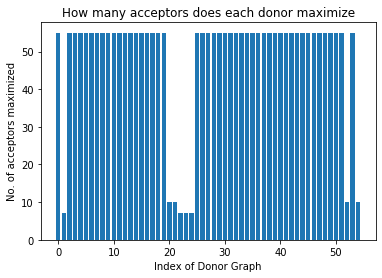

In [33]:
graphs_idx = [i for i in range(len(g_list))]
plt.bar(graphs_idx, graphs_maxxed)
plt.xlabel("Index of Donor Graph")
plt.ylabel("No. of acceptors maximized")
plt.title("How many acceptors does each donor maximize")
plt.show()

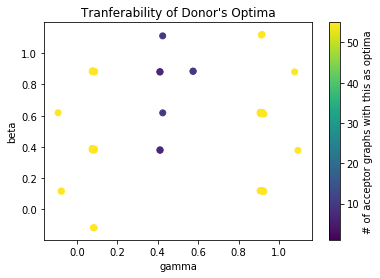

In [41]:
gamma = []
beta = []
for i in range(len(g_list)):
    data = g_data[i]
    gamma.append(float(data[0]))
    beta.append(float(data[1]))
plt.scatter(gamma, beta, c= graphs_maxxed, vmin = 1, vmax = 55, marker = 'o')
clb = plt.colorbar()
clb.ax.set_ylabel('# of acceptor graphs with this as optima',fontsize=10)
plt.xlabel('gamma')
plt.ylabel('beta')
plt.title("Tranferability of Donor's Optima")
plt.show()


# Subgraph Analysis

In [52]:
def subgraph_optimal_param_and_cost(graph, edge=(0,1), p=1, seeds=20, steps=200):
    '''
    Optimize parameters of a subgraph, do so (seed) many times with random initial
    ized parameters

    Return: array of Results of (seed) many optimization runs and the index of 
    array corresponding to max energy
    '''
    results = []
    s = 0 #iterator
    max_energy = -1
    max_index = 0

    while s<seeds:
        gamma = [np.random.rand() for i in range(p)]
        beta = [np.random.rand() for i in range(p)]
        params, loss = get_qaoa_params(graph, edge=(0,1), gamma=gamma, beta=beta, steps=steps)
        gamma_opt, beta_opt = params[0], params[1]
        energy = (1-loss)/2
        result = [gamma_opt, beta_opt, energy]
        results.append(result)

        # comparing with max
        if energy >max_energy:
            max_index = s
            max_energy = energy
        s+=1
    max_result = results[max_index]
    return max_result

In [53]:
## My Code
def get_qaoa_params(graph, edge=None, gamma=[0.5], beta=[0.5], steps=50):
    loss_history, params_history = popt.qaoa_maxcut_torch(graph, gamma, beta,
                                                          ordering_algo='greedy',
                                                          Opt=torch.optim.RMSprop,
                                                          edge=edge,
                                                          opt_kwargs=dict(lr=0.002),
                                                          steps=steps,
                                                          pbar=False)
    best_ix = np.argmin(loss_history)
    return params_history[best_ix], loss_history[best_ix]

In [54]:
len(g_all)

56

In [55]:
sub_max = []
iterr = 0
for g in g_all:
    iterr +=1
    print('####################')
    print(iterr)
    maxx = subgraph_optimal_param_and_cost(g)
    print(maxx)
    sub_max.append(maxx)
    

####################
1
[array([0.7500261], dtype=float32), array([0.12502602], dtype=float32), 1.0000001788139343]
####################
2
[array([0.83333373], dtype=float32), array([0.12499999], dtype=float32), 0.8247596323490143]
####################
3
[array([0.6520326], dtype=float32), array([0.12499999], dtype=float32), 0.7721656262874603]
####################
4
[array([0.24995697], dtype=float32), array([0.8750003], dtype=float32), 0.7500000894069672]
####################
5
[array([0.74997634], dtype=float32), array([0.12499999], dtype=float32), 0.7500000894069672]
####################
6
[array([0.75004005], dtype=float32), array([0.12499999], dtype=float32), 0.7500000894069672]
####################
7
[array([0.625], dtype=float32), array([0.8750003], dtype=float32), 0.7500001192092896]
####################
8
[array([0.59795743], dtype=float32), array([0.4020438], dtype=float32), 0.6666667610406876]
####################
9
[array([-0.11072735], dtype=float32), array([0.625], dtype=

In [56]:
subgraphs_maxxed = []
for i in range(len(g_list)):
    print('####################################')
    g1 = g_list[i]
    g1_results = g_data[i]
    g_maxxed = 0
    for k in range(len(g_all)):
        g2 = g_all[k]
        g2_results = sub_max[k]
        sim = float(actual_sim(g1,g2,g1_results, g2_results))
        print(sim)
        if sim>0.95:
            g_maxxed+=1
    subgraphs_maxxed.append(g_maxxed)

####################################



0.7596304341436968



1.7957982344774965



2.813938596342553



3.788758148071551



4.656995601109669



5.50757700598563



2.9367638200078767



2.9708274900072196



4.03440009468067



3.816523580902826



5.113431749094545



5.197556398080682



6.178927855072973



6.280425019302823



7.234428013890027



7.3479719468672



5.178745106345698



5.2555966644594525



5.211163413873191



6.292821699650856



6.387671274905321



5.678091222925939



7.38693838884206



7.498030671477502



7.524073910179288



8.467116639738721



8.591916188436901



8.253204750563112



7.433057446270738



7.543176565107531



7.567857153511149



7.51803185331855



8.548382848113445



8.673320273569688



8.451507820330022



7.346894543878961



9.646579231254305



9.784719477470382



9.857213537454736



9.869135040762242



9.680892910770703



9.81956562467093



9.892066362328448



9.9034867361564



9.85222641146092



10.79367399051995



10.9448386183816



11.03634760457403



10.070397301157568



8.992760287277383



11.918828867083024



12.081869678994204



12.190224700300226



12.24684300719213



12.250188551905214



12.198337711277972
####################################



0.7646837796127725



1.2612946087940442



2.826394859872558



2.9422679655865753



4.671580811570445



4.5948094952301775



1.7544608708208824



0.9415290092882845



3.4262747412951664



2.8586596800842585



3.562401717090273



2.820927458177883



5.5411978751065165



5.139023200551736



5.5489344909785805



4.855457519281265



5.199227810082076



4.911087304387848



4.465105338895097



5.360600355689254



4.983391549588624



3.9866220754162516



7.410282742224393



7.102575592683467



6.677107015141364



7.428542389308757



7.050618688627422



6.277574890863447



5.50849895303125



4.797787852064563



3.963392532424059



3.0262948359395376



7.583883597780865



7.158361757814877



6.423240275481247



5.086251980596691



7.589981653908454



6.914895903338291



6.139609315021075



5.2764719282769414



9.707054087242089



9.370866079409303



8.939126395371725



8.422522464582599



7.8246486354682245



9.726399268888036



9.300358344058855



8.789051975447503



7.469134120060588



6.1722716904376655



9.735479434243308



9.08759520520463



8.354933536434002



7.54614530013592



6.665850718697756



5.71761507709567
####################################



0.7783265923408657



1.8302177504604282



2.856222883410015



3.8340909201029967



4.702544264531866



5.553285048281613



2.9875364700412286



2.9526653046266764



4.093421360950687



3.815902752938954



5.17613444323913



5.207813290508161



6.243225795385022



6.297918196761125



7.299990095765621



7.3710948890998855



5.246049282226986



5.271682951782202



5.169298602328544



6.363745784980281



6.4140247392266945



5.657354563453098



7.459386957318933



7.531068205510105



7.513731399751384



8.540786052333534



8.630146058173766



8.252826757643442



7.507490580308044



7.579207096235441



7.561619577353601



7.462122748451757



8.624233785975207



8.715533436346327



8.456878638936152



7.315618906327405



9.723570951498568



9.831720779692793



9.871774465829759



9.846454414323972



9.758060063254769



9.867535418813302



9.90844938148295



9.883535132448701



9.78852700939217



10.871902700540632



10.99725303668547



11.061007357958701



10.064105362514669



8.956605504391472



11.998056302434435



12.138452695052896



12.222581286039862



12.251903675934825



12.22323010210195



12.132258941296058
####################################



0.7757619694234233



1.825353645603201



2.8500112730290548



3.827113791458964



4.69516804133642



5.54551059068789



2.9802580560728935



2.966483336934537



4.0847184834485315



3.825190585836305



5.166547848435651



5.214909764857241



6.2329927336592865



6.302751137557962



7.289138891830383



7.373999344652787



5.23589958269484



5.277977449851262



5.193913920163529



6.352705575514527



6.417596583795237



5.674829819082194



7.447696702964852



7.5324981730755605



7.529445340637328



8.528472096816063



8.629744441500966



8.264725324905335



7.495562271619191



7.580182730560898



7.576632888792624



7.493051772868153



8.611659069212589



8.714472971030276



8.467885526070608



7.336982511763638



9.710374118070392



9.828914449389234



9.880103778793691



9.867185070464211



9.744843453194296



9.86452799829194



9.91638042768757



9.903655577591602



9.822681080763425



10.85806678669814



10.99257236225679



11.066082304461972



10.078529140583552



8.979514827164252



11.983602799853688



12.132157977599606



12.224940795517657



12.263760219610013



12.2458140609146



12.167346695470242
####################################



0.7586605619166702



1.793877134714107



2.8113890253855836



3.7858061467253377



4.6538142430524525



5.504202614153745



2.9338317955601303



2.9727994879477144



4.03079924864773



3.817263910397506



5.109372372472519



5.197467870732258



6.17452835803087



6.279644282784501



7.2297383582991195



7.346610157118186



5.174459585113331



5.255235321452961



5.215220451010347



6.288069920601684



6.386447035555211



5.680485663320194



7.381841797730199



7.496131977651442



7.52568525341971



8.461725893900484



8.58945096807929



8.25388903299745



7.427836680078111



7.54110921894235



7.569249391371179



7.523321332118988



8.542816275216952



8.670596514973099



8.451863430404483



7.350120265081683



9.640717761229734



9.781444620980741



9.856730606752164



9.871750775099548



9.674980742149055



9.816202011642307



9.891453516371415



9.905928394972447



9.85814532321644



10.787467225617732



10.94093816158925



11.034921875157549



10.07158307873638



8.996330885959466



11.912327909900492



12.077444676922829



12.188016652946066



12.247065368171862



12.253137438311576



12.204419593757645
####################################



0.7584841272252736



1.7935358840635787



2.8109478060217903



3.785308980196196



4.653292406115389



5.503661886274702



2.9333165092386433



2.9729679445126007



4.03017796834387



3.817250012601297



5.108686537441766



5.197325317453352



6.173800542107579



6.279408552725751



7.22897712598393



7.34629962773163



5.173730356951198



5.255040858902891



5.215631715078212



6.28727549538649



6.386128581418058



5.6806747390283485



7.381005167630426



7.495723596492984



7.52574887545429



8.460855634847553



8.588970451042753



8.253836369630259



7.426977180513368



7.540670386700741



7.569274127010148



7.5238759260906765



8.54191489823113



8.670071033677175



8.451751838701817



7.3504154246374185



9.639783033842596



9.78084978226644



9.856503900810118



9.87193766106143



9.674037944963604



9.81559285631816



9.891205777701307



9.906087093358668



9.858775470880085



10.786491475111042



10.940262177775738



11.034568615422474



10.071589265573218



8.996673220508143



11.911319560509192



12.076704013877473



12.187562757414511



12.24692917629089



12.253363312725204



12.205070047971601
####################################



0.7443463855107093



1.767074788286575



2.778164563273168



3.7502685448799906



4.618703367283437



5.47010558496015



2.8939693910803297



2.955042239777482



3.9841782855729835



3.7909391420955827



5.059939953154868



5.163583062006768



6.1244947221002946



6.2430419142887885



7.179993423891173



7.308732374301996



5.121032781883212



5.2167120848364315



5.19440221360305



6.231876852895227



6.342531054696769



5.6541474667750995



7.325115943533443



7.449729226061586



7.491123788472664



8.405348414791929



8.541970264611948



8.21816110005788



7.36896980351559



7.492058962589



7.531506776550755



7.500017130887821



8.4835152321719



8.619301146010443



8.411011812769726



7.324349546699669



9.581850630350544



9.729279576638989



9.81213561823935



9.836725979005747



9.615345161812563



9.762883500462904



9.845300344761334



9.868924865964713



9.833562874483556



10.72835227452753



10.88693967816059



10.98669970070496



10.034415284349615



8.971190501225212



11.853809874888922



12.022927248533094



12.138014871026591



12.202833378438859



12.216751242312226



12.179060811140907
####################################



0.7436734648322952



1.7656152149992612



2.776052813781863



3.74762444999253



4.615657844806888



5.466703634493246



2.8916564934965074



2.9602175374282136



3.9811653468287913



3.794582022279724



5.056332107259806



5.166388655367334



6.120367314768718



6.244876372179996



7.175397741096588



7.309700552415315



5.117294866580834



5.219366148911156



5.204172553880245



6.227527435860404



6.344090594511436



5.661314928112843



7.320234662987611



7.450326164274772



7.4976848599930035



8.399988902310321



8.541708514513573



8.223167975694613



7.363998000512169



7.492533632878837



7.537905650908798



7.512874863880319



8.47800364041458



8.618823088861532



8.41580966977653



7.333500513559536



9.575854552411922



9.72795227883532



9.815812425672968



9.845809300582951



9.609288074973591



9.761463001278688



9.848848062148535



9.877839162469801



9.84832726983158



10.721806241555702



10.884679847176644



10.989007584122941



10.040983399613657



8.981411491181928



11.846771440237198



12.019837628906705



12.1391140854893



12.208421209849547



12.22719871498591



12.194828831657828
####################################



0.7539690881402703



1.7854678462949158



2.801498797421997



3.7758660137616142



4.644664696158413



5.495953738735355



2.9215920525064165



2.9608749509710006



4.017025907121475



3.803966258976356



5.095452646436753



5.182539801926519



6.161176571284217



6.264988051009139



7.217168232242281



7.332595540909535



5.15917716501857



5.238710794407523



5.1977114532983855



6.272687491561143



6.369361871890959



5.663875140726773



7.36707440362253



7.479408455375067



7.507041405858602



8.447778554739369



8.573443832008431



8.236629499736509



7.412409387860726



7.523562323666464



7.549616139936957



7.502231478359742



8.528055815849923



8.65350013664147



8.433022065942122



7.332111662190643



9.626820306866088



9.765138436561472



9.837973387917081



9.85086927854418



9.660935134739885



9.799634356208262



9.872317214180208



9.884547874228575



9.835253083102819



10.774324876279172



10.92522484329029



11.01657646388154



10.052706877777922



8.977916881312911



11.900122928036403



12.062637682446665



12.1705385987993



12.22706273316919



12.230990374838855



12.180840600770384
####################################



0.7533779655238085



1.7841341245498632



2.7994994903459163



3.773284024394739



4.641612112462636



5.4924713198827675



2.919446883522173



2.9671915569604557



4.014164658704237



3.808555203375539



5.091943219497627



5.186211407883958



6.157073654476754



6.267532458488894



7.212515367543218



7.334122560538964



5.155571895033417



5.242260515302979



5.20921251667709



6.26841439898364



6.371672354057602



5.672361797769196



7.362192716822536



7.4806036246713035



7.5148456874432465



8.442334544602115



8.573631775277462



8.242612212032842



7.407454735487144



7.524646507209236



7.557261806232287



7.517042339156717



8.522482097495347



8.653481415481167



8.438805163062167



7.342640172320777



9.620675833355602



9.76412395689634



9.842453938035197



9.861296203515623



9.654734386459035



9.798525036143673



9.876660007380297



9.89478945548571



9.851947062232547



10.767546978144972



10.923131321388555



11.019472607479821



10.06023068524625



8.98941759645013



11.89276275846456



12.059570862212079



12.172024541806586



12.23343506831956



12.242669987479108



12.198358580748375
####################################



0.7325756510415704



1.7438271514170105



2.747673373065506



3.7157177231284444



4.582614882515781



5.4333130645729515



2.8585338120379147



2.951711284266146



3.941040540564521



3.7774331578566436



5.012126970747336



5.141553781230864



6.073955437412718



6.215930999507253



7.127813314675503



7.278046718247819



5.07002873091233



5.191101433875405



5.197962089676671



6.176138108802049



6.309468904565086



5.6475137213281466



7.266634263154325



7.411683823988891



7.475837901284758



8.34522216678785



8.500444001558275



8.198065058991709



7.308497697619256



7.451666124141729



7.5134864088113575



7.507566496930265



8.420324549954385



8.574055356432076



8.38634353882818



7.321813413126804



9.517044311875814



9.680676681579502



9.781238350505655



9.825784062500487



9.54947446594445



9.712919330154534



9.812728302252296



9.85597858671218



9.84336469832325



10.660905529451284



10.833743818195503



10.948979041048327



10.015888947631327



8.970880476765863



11.784826862782529



11.96661539616382



12.095389838244138



12.175470871151937



12.206870013686212



12.18969163125161
####################################



0.733281430209033



1.7451073116621199



2.749175560085727



3.717189040151713



4.5838842749276845



5.434320002880141



2.860408304685616



2.9554972767987273



3.9431453249440005



3.781164278026639



5.014212982114553



5.145499805941797



6.075864573894217



6.219644617885973



7.129461210433253



7.281433897550856



5.072359722036277



5.195321905464297



5.204200641057485



6.178441875886457



6.313625121441423



5.6529671410978795



7.268751599219634



7.415599584021348



7.4816644466729185



8.347069214133944



8.504025182095155



8.203238859647909



7.310764065835948



7.4557487994453515



7.51949516831304



7.515544376537862



8.422394300189838



8.577887769087361



8.391861030679324



7.328231261591274



9.518834484055402



9.684165336358951



9.786516928126577



9.8329037912496



9.551337774948328



9.716491881780602



9.818100744737999



9.86320100723393



9.852444879851932



10.66248039053669



10.836963976863368



10.953926758433026



10.022006945296575



8.977817717013105



11.786105264215061



11.969475565478072



12.099906239422742



12.181694457034482



12.214827643804576



12.19938090838548
####################################



0.7503085214556561



1.778568637379515



2.7928787904293157



3.7665601104145834



4.635374393270939



5.486833106524906



2.911298973136492



2.9568224286656934



4.004918802544764



3.797560967644326



5.082523473652297



5.174074037861093



6.147984569796988



6.2556755171315945



7.203943163517028



7.322812503468824



5.145238863052824



5.229071363047707



5.193142311938853



6.257934506815942



6.358191385546487



5.65762726806864



7.352072640722596



7.467449233875298



7.498550413299784



8.432756149781099



8.561063641690813



8.227646107756506



7.396861979470526



7.51092604586725



7.540309051288084



7.497095028521016



8.5122820640904



8.640136240682786



8.422717572325766



7.3260074221624505



9.611045509851497



9.751406304755609



9.826531794356619



9.842261231007253



9.644958218470142



9.78559913450705



9.860466264321662



9.875419874247326



9.829723051481771



10.7583672024392



10.910869586896524



11.004014143911634



10.043304425157604



8.971886519216824



11.884202448263931



12.04800340298412



12.157340798962679



12.215646047291056



12.221916018284611



12.17495985382493
####################################



0.7464683070384335



1.7709779811307587



2.7828742171543124



3.755114295069068



4.623243879608427



5.474226198455964



2.8997246834071926



2.9629286858019217



3.9907769407971783



3.799235061164244



5.066730403521432



5.172750171122261



6.131096563985039



6.252024410522627



7.186237220224647



7.3173133770076655



5.128472081336748



5.226615975416833



5.206828971201219



6.239492288988638



6.352675434389904



5.66550097987888



7.332524191701408



7.459663345071855



7.503685370947838



8.412381851838589



8.551479834819368



8.229705621391535



7.376739823462472



7.502413960229808



7.544545621162271



7.515628579040195



8.491056291340751



8.629416555387486



8.423404746806458



7.337347136979301



9.58899765773393



9.738944617679506



9.824419672227778



9.85159905675102



9.622636075283364



9.77273175547063



9.857806824454965



9.884058631082317



9.851149214180374



10.735230491822875



10.896313833052059



10.998666250150793



10.047652260919024



8.985045506151048



11.860258851791254



12.03180717505048



12.149416462905743



12.216769720585475



12.233151995762341



12.197744966960038
####################################



0.7407553786760075



1.7595683670083855



2.767686851184866



3.7375835215876183



4.604527741260653



5.454674806211431



2.882248087507402



2.9661277313655097



3.9692766358830918



3.7965680110052253



5.042555121080558



5.165500860658018



6.105094265701261



6.2415162650313185



7.1588617671838515



7.3042384291150135



5.102850893761358



5.2177281275376455



5.216964654069437



6.211151116631639



6.339448024491006



5.668780945196267



7.302332647330165



7.443227705429206



7.502453141543842



8.380800867241259



8.532522825951778



8.224791592732675



7.345665153788612



7.4849091102523655



7.542036746053625



7.530010902195957



8.458130113751112



8.60876812248483



8.416416582848132



7.343943469558597



9.554684148402071



9.715834734055248



9.813471355512533



9.854164597672797



9.587865449099153



9.74900545402164



9.846071739500415



9.885656020452227



9.867893636724137



10.699081129454937



10.870186497113787



10.983350732844155



10.044588455725856



8.99328096343228



11.822740445999965



12.003334078488882



12.130651670862001



12.208673787667621



12.237029941845913



12.215343568314857
####################################



0.7436762813685422



1.765531980849277



2.7758119946089805



3.747187215523469



4.61501901697503



5.465865556405425



2.8914696763700074



2.962554706353976



3.980806529902042



3.796458352187478



5.0557589292031855



5.168041982460641



6.119560040800507



6.246159234984665



7.174354025707485



7.310621459024336



5.116753714111244



5.221055706038014



5.20832659423501



6.226763241460099



6.3454182733483



5.664530441410859



7.319229013284634



7.451281492113342



7.500765700597247



8.398740605518286



8.542300100340025



8.225623794993814



7.363003603844311



7.493497592804753



7.540989728528588



7.518232392958824



8.47676177272328



8.619413188935855



8.41828891723524



7.337436356094323



9.57436500838234



9.728177543085167



9.81787017786341



9.849821510139465



9.607793679401198



9.761678263522768



9.850889562272311



9.8818275610995



9.85439183225739



10.720059930054926



10.884529758168577



10.990554190981756



10.044031005291084



8.985702616769709



11.84476964557195



12.01932210331962



12.140171743258568



12.211147463094552



12.231700495451642



12.201227106131805
####################################



0.7581532676508147



1.7927691174489575



2.809773344823719



3.783766403072656



4.651445276406532



5.501535339304416



2.932071260543104



2.9753303054180935



4.028493539844457



3.818764879490944



5.106593438878292



5.198277027155155



6.171327213579088



6.279747012369189



7.226149573164619



7.346080851349915



5.171588834512032



5.255933275549757



5.219910997823764



6.284712449641481



6.386349547915816



5.68360245582065



7.378051914396104



7.495333360897038



7.5281574833472105



8.457539994117623



8.588024491879924



8.255384353276396



7.423983420382467



7.540222832020317



7.57160456579778



7.529251849996167



8.538523842070768



8.66901542293903



8.453177998532878



7.353984946904348



9.636023878184929



9.7792415016359



9.85720864476461



9.875155453451953



9.670244128533751



9.813932729645892



9.89183971666864



9.909213214709549



9.86463946065189



10.782325161750205



10.938052889367585



11.034452318852232



10.073543086498043



9.000438946028854



11.90677721596622



12.073949052807158



12.186710998201495



12.248128876128398



12.256801315490373



12.210981877198199
####################################



0.751670658099359



1.780893993228893



2.7954149672241093



3.7688254697638413



4.637102803789186



5.48798120541469



2.9145970825074587



2.96651491201322



4.008423199740471



3.8065808218785175



5.085759325985582



5.1832155019079025



6.150700035438244



6.26400508730955



7.20605556882109



7.330241980227247



5.148928024454482



5.238727837116831



5.209263629866283



6.26132916730283



6.367292405205342



5.671189469870543



7.354922230960804



7.475720303696363



7.512626477336526



8.43498184973959



8.56841916049213



8.239888962958304



7.399935597735603



7.519450688371173



7.554661236966377



7.517507769734326



8.514786446269653



8.647811543690699



8.435481096429887



7.341957495052765



9.612905624900252



9.758150125206102



9.838447527404403



9.859571206297819



9.64687154986472



9.792408149985546



9.872457017350408



9.892811621065528



9.852669969002486



10.759617766870337



10.916733719915271



11.014742493205471



10.057676319859612



8.98901193874943



11.884774438865136



12.052912436678726



12.166806567073783



12.2298646888205



12.241062744312618



12.199174868396987
####################################



0.7218095196790356



1.7214764017014388



2.7167995381870003



3.6788541314462213



4.542106607310953



5.3900491240060235



2.823731338777658



2.9529647786951245



3.8971217136321883



3.7673509727284253



4.961444493663109



5.121401515924274



6.018167517961447



6.188456769371797



7.068001734675208



7.244642316632899



5.016720494920454



5.168114290659454



5.209617170040264



6.115911106380479



6.277100985799233



5.64657732043818



7.201203854738362



7.371973357337874



7.464667678454456



8.275697529855591



8.454793308246897



8.179504928453195



7.241271523976517



7.4099203165777165



7.500010942001292



7.525528452952216



8.347850453871589



8.524995474218299



8.363727676000776



7.3261102194421275



9.440448441144316



9.625714948609623



9.749840045806106



9.82030103164125



9.47173284901563



9.65659426349194



9.779735541830446



9.848654695858196



9.864599355483827



10.57903375747744



10.771571944262746



10.908127785802423



9.999961480236777



8.977674489112282



11.69882494662983



11.89865556335779



12.04685359928524



12.148104628526495



12.202866309386037



12.211797200191109
####################################



0.7301523480712583



1.7388586526540335



2.7408958332971776



3.7077239105361603



4.573931179111455



5.424132895711175



2.8508373718510214



2.953067382338677



3.931411531756881



3.776180313316154



5.001119691991603



5.138166296065731



6.061951150296596



6.210974849759788



7.115051126521214



7.271842557524273



5.058412785201895



5.18704753268091



5.202506133813127



6.163114812743709



6.303372059808708



5.648986387555429



7.252596721889495



7.404023363009382



7.47522608848831



8.330414764206475



8.491541875745323



8.195733864922884



7.294053693377847



7.443536256805307



7.5123340861376136



7.5141717437214695



8.404860173864808



8.564376309200291



8.383099217414534



7.324892200658618



9.500807034807407



9.669771508506727



9.776120472438032



9.827027991923329



9.532988515338392



9.701708970400949



9.807244889591653



9.856792460779888



9.851197022119283



10.643647408972056



10.821325559896987



10.941780795922515



10.014535840430726



8.974826275000659



11.766798718509726



11.953007413326397



12.086524383408666



12.17177001003516



12.20887493264499



12.198091933579496
####################################



0.27448886302171144



1.182637769550341



1.156828501926828



2.4905023195329483



2.1081290314497707



3.6041531156394604



2.2350594473105416



2.949523492002223



2.2221292271781548



2.9168601479775296



3.686537261337173



4.432324343981531



3.3458903459024425



4.241031205019804



5.075296645581461



5.843063526330637



2.1836048763985496



3.066976424333959



3.9832508007762675



3.677771316657422



4.616034177910479



4.957516531885412



3.3123729020910067



4.219563481760451



5.154980935197596



5.073491581975141



6.030838940924825



6.689561085788226



5.225498734366296



5.9964329971618



6.760143081657382



7.512397500265043



4.867846434816966



5.790201027302882



6.5182312146908



6.479359480155796



6.671347541566693



7.467634713746578



8.261929845379472



9.049772645129377



4.490230499543608



5.412481591206945



6.3567561740678595



7.313943193364563



8.272403115415466



6.305493465362234



7.247617496028935



8.202738846368199



8.339249166234685



8.252765156310769



8.153359096914752



8.974222965019996



9.794103615814743



10.608924504939363



11.411842925069404



12.196441575816815
####################################



0.27349663226782256



1.1824360458332284



1.153572287964498



2.4893584237109407



2.1032857279954698



3.601679898549556



2.235938758755434



2.9454564675435444



2.2197756337565746



2.9189278860839463



3.6864912441921844



4.4282487320952075



3.3417752513157124



4.240518227027799



5.073762351777343



5.8382808918278695



2.177775659432219



3.0661847645685514



3.988139273445692



3.6742512422731606



4.617301501075373



4.96332687906089



3.3046115828032527



4.216926392193017



5.157963101391268



5.068333891933911



6.030595354705457



6.6943958360175735



5.224406289901179



5.992215900336806



6.75257705289568



7.50117872074136



4.862482241711569



5.788755097198167



6.520935837816135



6.485602876050769



6.668675892368507



7.462587570879905



8.254380612369387



9.039512567796878



4.480476739468789



5.4078196902367495



6.357574256662862



7.320438510282577



8.284582665130225



6.2984245974392925



7.244675819414711



8.204200262742203



8.344874768420722



8.26195078791999



8.149041355742519



8.968243331388829



9.78639959117837



10.59935976117137



11.40020185807739



12.18241743464287
####################################



0.7637191652582296



1.2609937784192473



2.8235079219253345



2.9406802970207915



4.667528113234165



4.591593029545147



1.7550853893209821



0.9561712640264386



3.424166179230887



2.8564638299274887



3.561721106043966



2.832185634142444



5.537791837082042



5.137325241165227



5.546406028677595



4.863334858621154



5.194182285756641



4.9044630164309835



4.456871927010641



5.35696890662631



4.979303533514462



3.9825993526678447



7.403802000617378



7.094687283199309



6.667784347250884



7.422926648423095



7.044374577319457



6.27102274229083



5.506359865025535



4.805832853533551



3.982424558922052



3.057283570955654



7.5788759389864495



7.15461487999486



6.420962212234069



5.085264441217698



7.585884772889573



6.9196558152700725



6.153806157694193



5.300832216177739



9.69910140978125



9.361926374461536



8.929200373813138



8.411882489136948



7.813865602484173



9.719342825673518



9.294209509943187



8.783906150318032



7.465231700471463



6.169146524793706



9.729346495164604



9.089133349794801



8.364569140591023



7.564416864219128



6.693427786521212



5.755345607184973
####################################



0.7638540118798108



1.2607375952754984



2.824722523097334



2.9394849829705603



4.6700992790109686



4.589490792620065



1.7543421552337395



0.9410725964873082



3.424991009398327



2.8597608010188305



3.559937780270241



2.8179188849281585



5.540111730359949



5.140465066008239



5.543539166319806



4.849516283033454



5.196696401624937



4.910984777980175



4.467734567880309



5.3568306802336245



4.982019402558538



3.987777273420508



7.4079147045507385



7.1027836086169325



6.6801205003481146



7.421745057906381



7.0461730103810165



6.275794935528657



5.503449423378889



4.792151797772965



3.9571890066609554



3.0196132811777354



7.580251489402644



7.157153999475182



6.424613310148315



5.08975045140743



7.581835214251752



6.906234202142013



6.13046309876193



5.266901739968332



9.704888773640269



9.371429463292486



8.942602848197023



8.429090664097451



7.834487604056763



9.719683833376381



9.296000860954445



8.787226968791098



7.46988783707563



6.175163142589129



9.724122168409215



9.075830125521067



8.342799787854528



7.533688236524254



6.653126574813725



5.7047080142307625
####################################



0.7634438064586426



1.260704460339157



2.8232371047808553



2.939260138353669



4.667739021333114



4.588933526075502



1.7548162201470296



0.9530165257085811



3.4239259038131338



2.8575279084300944



3.5602452480214284



2.828058355699321



5.5380776336465525



5.138691024309847



5.543486873583198



4.85803153262822



5.193975956727175



4.905861899367016



4.460039688513316



5.355491563356129



4.979192554662049



3.9838443945143567



7.404139918858168



7.09668657968272



6.671569334023708



7.419981443946782



7.042792647215429



6.270932019374733



5.503559539118679



4.800657837763724



3.97472927276814



3.0469419997222653



7.577907457274116



7.154729027776897



6.422202308644619



5.0874024408766205



7.581561345190924



6.913232622855367



6.145186389563182



5.289915312634932



9.70002150494699



9.364524233902035



8.93357198888613



8.41807675027005



7.821882673381365



9.71688793555385



9.292852416677636



8.783723868349146



7.466215404165842



6.171140497141623



9.723445820905123



9.081405011654232



8.354950501927776



7.552831979327245



6.679786894320341



5.739547387891923
####################################



0.7755095726420044



1.8248902806176333



2.8494412637313964



3.8264986255900406



4.694542244892649



5.544871689946885



2.9795754793154083



2.966919314623125



4.083924079079828



3.8253550433256143



5.165699481317015



5.214916363808601



6.232114304987927



6.3026371520443165



7.288230973883457



7.373785600689479



5.234992822293424



5.277906891930648



5.194784713849426



6.351745524466957



6.417366735379088



5.675346077300886



7.446707311278124



7.532156428360277



7.529813915905672



8.527453515323609



8.629309682275457



8.264915973668604



7.494550235799134



7.579802813148125



7.576946026452514



7.494174641577707



8.61061890609314



8.713988813809488



8.468001668243176



7.33767221444833



9.709305595701093



9.828343334912935



9.880069102832739



9.86776230529738



9.743776295651022



9.86394597328334



9.916321577868656



9.904194498817258



9.82393363879262



10.856972092833765



10.99190842952471



11.065880181821571



10.078819928618818



8.980274928612559



11.982481172751774



12.131416125124153



12.224604154159112



12.26387697369888



12.246457683573382



12.168627835448039
####################################



0.7755880336719662



1.825315990861486



2.8503708598297357



3.827981386399265



4.696531218609214



5.547314156091407



2.9804071541103



2.9563851061378905



4.085304679991147



3.816993014298611



5.16768673432527



5.207450145155184



6.2347012531091215



6.296559364259252



7.291368721154175



7.368942788789528



5.236952737045976



5.270452747035558



5.176937995244653



6.354335872499247



6.411388384013472



5.661702660928889



7.4499160916115645



7.527539872649166



7.5167256381526455



8.531227742755084



8.625904759833354



8.254296532114777



7.4977895862159425



7.575273969476205



7.56401623326455



7.472058727600348



8.614491335122013



8.710798260360605



8.457564865497247



7.321616426693798



9.713754906031612



9.826343125847304



9.871185641431477



9.851415556830881



9.748293418656349



9.862072071865533



9.907629103163199



9.888109838155623



9.79971013744837



10.862075207616579



10.991205042686556



11.059012691827206



10.066519588726008



8.963324920763286



11.98817743351929



12.131865039467094



12.219506121311428



12.252811053422219



12.228864744811265



12.143777778754586
####################################



0.7707687631204239



1.815507427332345



2.8369279279379875



3.8118563569596318



4.678517355499969



5.527555291448029



2.965260298971557



2.981925663697902



4.066276920574836



3.833185018395311



5.145637071455121



5.2182115282115475



6.210097030467402



6.301776483094551



7.264397649177771



7.3693175621511156



5.213931485656992



5.279893525038785



5.222619672896639



6.328224511711904



6.414404438567305



5.6929492867923885



7.421200206427834



7.52516888206488



7.543102769095544



8.500101478359623



8.61881651458824



8.27237041553821



7.468549148843719



7.572033052507144



7.589124866418745



7.528963557823868



8.582619170278715



8.702314578948172



8.473850250669676



7.359561211393666



9.679449231956204



9.813261802453553



9.880907271953989



9.886342414611478



9.713771203533286



9.848471778025491



9.916502635577384



9.921833706372716



9.861617595557583



10.825104100142259



10.973112937615028



11.06109090632517



10.088562633551453



9.003344780828952



11.948744724831133



12.109370396975406



12.21502798021852



12.268008792459774



12.266055664792285



12.206174416892795
####################################



0.7477109735289441



1.7734734995315444



2.786219308399067



3.7590079599872808



4.627440193784459



5.478653656942351



2.9035563347779383



2.9604748082916914



3.9955141556170726



3.7983376366444195



5.072091746993883



5.172911004641353



6.1369068189214575



6.253058177132893



7.192404076129771



7.319062168023526



5.134137850029038



5.227128291403896



5.201537880415974



6.2457936620635675



6.354295388386493



5.662319158147448



7.33928112606233



7.4621404356413



7.501465682730356



8.419500390172113



8.554658080749421



8.228649635443377



7.383681205498717



7.505123382163431



7.542613024609141



7.508522749417953



8.498454806527832



8.632965133777896



8.422788721470987



7.33290076745206



9.596758521143508



9.743177989504941



9.824847348141502



9.847838493067801



9.630491368969562



9.777101806969155



9.858416875341144



9.880529633780277



9.842976970071033



10.743447327329449



10.901352605157987



11.000297000032441



10.045742770908072



8.979951081753013



11.868836074518763



12.037500084577404



12.152031563689691



12.21603343146975



12.228698170802653



12.189088493484475
####################################



0.7433754509312387



1.7641653367803907



2.772875232831778



3.7424320910285083



4.608471747547494



5.457571011425644



2.888865043178852



2.9741760787224467



3.976493778118689



3.8049258638758867



5.0494548752011275



5.17433093463779



6.111148725870569



6.249580777416554



7.163846798446111



7.311243759786404



5.110638468826229



5.227574469611686



5.228879292550078



6.218579637218074



6.349102215494016



5.679407990274566



7.308873796264275



7.452062448050055



7.513676084134148



8.386235536322639



8.540248950517272



8.23445932471373



7.3526894961040545



7.494313662896088



7.553914189706107



7.544153281566097



8.464224512014788



8.61729856642353



8.42714449714806



7.355317962911387



9.559635071135142



9.723208235099257



9.823379415318191



9.866525613309628



9.5929904605653



9.756611669333964



9.856272074442005



9.89836872685395



9.882826638179644



10.703028369126839



10.876592409900267



10.99232818692429



10.055055932272026



9.00454013721383



11.8254799290841



12.00850269674725



12.13835967238952



12.218912071328043



12.249662699478288



12.230068854458604
####################################



0.7496138817673047



1.777228936555326



2.7911606668054514



3.7646512865642086



4.633410871599632



5.484849180954234



2.9092786767653296



2.957110587343275



4.00249762083379



3.7972095887976773



5.07988009118178



5.173258895677203



6.145223795481164



6.25456744273744



7.201112946611719



7.321492792491307



5.142410194048601



5.2280403329183285



5.194156849439098



6.2548823503597895



6.356734184206356



5.657919795022621



7.348903601914327



7.465710442006552



7.498392749667369



8.429518322578504



8.55912306308905



8.227148190036656



7.393588032603182



7.509055310119295



7.539989765913105



7.498554854816596



8.508893769690077



8.63799591967793



8.42196743753954



7.326665564705912



9.607590785835782



9.749074781127701



9.82541962081413



9.842525084312488



9.641458585894837



9.783200505318124



9.85926329113891



9.875567837419092



9.831447526107203



10.754803887052454



10.908289650167617



11.002495184368762



10.043005116258668



8.972739668993214



11.880577978257437



12.04525080740795



12.155524026496387



12.2148719372682



12.222339874353056



12.176800362356495
####################################



0.7447156026000774



1.767576430466251



2.778487874741734



3.750220532448554



4.618197842412213



5.4691274405076635



2.8945803927154863



2.9624000353733484



3.984588328962736



3.797263558299932



5.059952162932662



5.169605058289356



6.124004089363158



6.248209982424684



7.178966007850299



7.313034639166789



5.121220640747692



5.222930173814232



5.207241408697002



6.231646754491554



6.347981022981055



5.664491622481823



7.324365028658795



7.454320797834226



7.501480892617156



8.404045367618167



8.545691846318174



8.226859259236345



7.36830366650035



7.49673549026828



7.541941439366485



7.516581725068616



8.482312456576762



8.623114318795874



8.419908237702128



7.336911287038814



9.580082317294302



9.732218919303229



9.820087829127376



9.849993432006373



9.613591951321954



9.765829415101708



9.853247649571008



9.882172364646932



9.852415333059964



10.726021802775943



10.889009175762721



10.993430447984945



10.045020838110053



8.984922216680097



11.850892131505352



12.024118983471473



12.143542552620408



12.212937192111552



12.231691653071607



12.199121881684693
####################################



0.7429272582165513



1.7640622030572772



2.7738943325027345



3.7450217555585508



4.6127597846666095



5.463558519178027



2.8892358053781213



2.96246793930422



3.9780968422918823



3.7957149666686814



5.052763400066614



5.166765090575203



6.116396525425227



6.244556068583353



7.171083625279436



7.3087821965420385



5.113558563784557



5.219552357785849



5.208761644281203



6.223278963330315



6.343443054505562



5.664285681698764



7.315575923716065



7.448987693492854



7.499982718551582



8.39498040349245



8.539777180952745



8.224513403725213



7.359230591744216



7.491059651131099



7.54003620461919



7.518977484296559



8.47282163314726



8.61666602302313



8.416899149780143



7.337484128625446



9.570319579934301



9.725209851163482



9.816078099758284



9.849354740781955



9.603688888304728



9.758631188472021



9.848996865179261



9.881237775593862



9.855314685532772



10.715852288226234



10.881270620688909



10.988323268864292



10.043050207215158



8.985906345921775



11.840461536172075



12.015858543031694



12.137618894433619



12.209609379535435



12.23132457765875



12.20221638772723
####################################



0.7459675418631417



1.769922068102911



2.781386487536587



3.7532956754017515



4.62119209956537



5.471972677169443



2.898070038840092



2.964855412143347



3.98865974996678



3.8003249592365256



5.064241778948968



5.173288981886884



6.128297651219922



6.252026919728516



7.18316544402034



7.3168471647506035



5.125877263305745



5.227032849484459



5.210619547652742



6.2365165689663655



6.352465876921255



5.668034744606371



7.32923143460068



7.4589217461695725



7.505734142193531



8.408810817131007



8.550273205754651



8.231001675883217



7.373377455701467



7.501583267462757



7.5464819373136045



7.520608546971638



8.487372942040924



8.628059380007949



8.424531908457414



7.340655979757453



9.585032986077564



9.73712767222608



9.82491398835366



9.854609610372286



9.618629122243748



9.770853949502206



9.85821990677533



9.886965661741913



9.856804852084345



10.730940241119054



10.893981815433277



10.998429282475508



10.049501445319345



8.98872753583847



11.85568384780715



12.029026224173451



12.148545898830703



12.217960311986856



12.236595262004052



12.203684274337768
####################################



0.7633011219976167



1.8029722421455054



2.8233304559143795



3.799490659373994



4.668428197093787



5.519592679360546



2.9476477854912724



2.9602688233222882



4.047639781255111



3.810975308663524



5.128207186864704



5.195013491000817



6.194793111221491



6.280526633101113



7.251213230481747



7.3502772392880935



5.194390209707365



5.2541307888767035



5.190507330365832



6.310023670685701



6.389512206015569



5.66461284464977



7.405241571447085



7.502425255158201



7.513251285144598



8.486350026990385



8.598439574474924



8.246272797446949



7.451820216679835



7.5482263650642905



7.55791233604865



7.491212984402846



8.568245571665477



8.680836351691385



8.445825073332262



7.329334766577103



9.667371107678889



9.794290235978808



9.854708164040595



9.853243753830892



9.701850820422925



9.829469559768016



9.890075409931125



9.888304678122905



9.822028209007339



10.815556846892715



10.956730364436199



11.037550227032003



10.060783601082615



8.973337037265422



11.94163276990102



12.09569213328971



12.194483839471868



12.240634518821839



12.232243021421747



12.166896350806653
####################################



0.7611466697613247



1.798841026410223



2.8180335147592466



3.7935668281623545



4.662247530697074



5.513212370717488



2.941434363328555



2.9654418012403267



4.040192210052282



3.813475784286888



5.120033134419121



5.1959362305036265



6.186159617307636



6.280142529033224



7.242210680818801



7.34883242904911



5.185688096785496



5.2543979374714125



5.200846107623504



6.300589777627053



6.388084797188145



5.671228967872352



7.395347290110642



7.4997484676056425



7.518476083823659



8.476085264096836



8.594749408665542



8.249559950838599



7.441657927382911



7.545165900703541



7.562623070200439



7.50472996314963



8.557628230924474



8.676580908844675



8.448386174274972



7.3381079386131605



9.656387570490036



9.789067205961477



9.855686956485943



9.861135559435894



9.690784959272284



9.82406740004845



9.890770336804504



9.895800404296228



9.83733977186144



10.804130252085761



10.950401362296923



11.036676604564315



10.065481899593774



8.983139933056798



11.929850140180498



12.088470687881681



12.192120144033133



12.2436121461356



12.24125601373042



12.182923501889146
####################################



0.7608352958390712



1.7983607599699518



2.817587405496198



3.793272064314705



4.66215281519293



5.513312569169051



2.940793250392967



2.9619139144058058



4.039593941607276



3.8103803764229176



5.1195942663866



5.192940849415205



6.185931230130567



6.2775199647956175



7.242196394939823



7.346577473776256



5.185142835096089



5.251283221927329



5.194921745670279



6.300213859909916



6.3852994828925285



5.6664271226983844



7.395190495857989



7.49733893907345



7.513641439744323



8.476149490529295



8.592709578569236



8.245462371996968



7.44146050001902



7.5427137105910775



7.557746817406071



7.497286562455287



8.557657771443568



8.674507569582618



8.444201020158093



7.332456290612478



9.656644470874843



9.78736555762989



9.851903463265263



9.855149678987583



9.691048212890594



9.822375133611942



9.887000362080917



9.889833570482088



9.829056531463811



10.804626369988398



10.949081990081895



11.033436872161063



10.060690177051725



8.97710841044387



11.930583648302056



12.087524561868998



12.189404249919512



12.239028882879404



12.234697681401114



12.174274286056294
####################################



0.7385025554268534



1.7551134451900061



2.761829720744835



3.7309215425833697



4.597533097552713



5.44749711158988



2.875453880921769



2.9652178983366886



3.9609910892632323



3.793742067941688



5.033344588476267



5.161023445097345



6.095318459956067



6.236047129092476



7.148716166256652



7.2980505973231935



5.093041485537872



5.212579561629996



5.217181349696186



6.200404164126413



6.332868742506527



5.667122066025814



7.291015963485254



7.435673386117909



7.499095873402607



8.36911232185098



8.52426548398161



8.220520022544372



7.333979794599804



7.476920272725686



7.5381735770537235



7.530869228153105



8.445878562872954



8.599827196095013



8.41129607971132



7.342988601895558



9.54206514328794



9.706212466428633



9.807128522413212



9.851520448125436



9.575054011236087



9.739136253871033



9.839424409572828



9.882646839307851



9.869101883181282



10.685908764889263



10.859658067822634



10.97569754350692



10.040560969305737



8.992699646560657



11.809213767336077



11.992166764202473



12.122036444972716



12.202904720950558



12.234517969040011



12.216648474948625
####################################



0.7334788125795381



1.7447004286430792



2.747435514192297



3.7136803310117594



4.578480931871292



5.426989029127487



2.8592502465364573



2.967006463672352



3.9405295539529375



3.7899907089899427



5.009671515040481



5.152445235070859



6.069141312302892



6.223817831330273



7.120468867406257



7.282773542406146



5.0681939497943835



5.202713387033642



5.224394447772269



6.172270697955132



6.318441095699139



5.667969715813687



7.2603294078149565



7.4175945757534825



7.494989718085396



8.336318282180631



8.503140237659109



8.212571164925556



7.302520387099197



7.457942657975208



7.533025869214144



7.541144217014452



8.411842129942169



8.577218939798763



8.401540494454872



7.346220745000769



9.505904601795718



9.680580331993315



9.792955118258215



9.849977738074276



9.538427980190683



9.712925224409046



9.824550919915803



9.880274462811114



9.880701699719545



10.647150975279613



10.830451933319015



10.95682296068806



10.033701103559395



8.99682061479481



11.768320379441613



11.95999459959841



12.09924971208331



12.190365129701537



12.233325286215825



12.228203384102796
####################################



0.7444787137314781



1.7673323021338



2.778497400445882



3.750640517230828



4.619087237415743



5.470493375041809



2.894359318764946



2.9550626294948175



3.98464812381649



3.7910723068276733



5.060455220060979



5.163806162739406



6.125034230698742



6.243317520659713



7.180546427580943



7.309044366115998



5.12158398779851



5.216976226438211



5.194337223227578



6.232473863134299



6.342873815959639



5.654197423923015



7.325737169997751



7.450122873757657



7.491264366458061



8.405983034402588



8.542398838328848



8.218353985569916



7.3696123809931064



7.492478474669987



7.53167811635956



7.499902614311349



8.484181589297792



8.619769677073627



8.411254724674432



7.324350977311818



9.582529943782532



9.729781335946516



9.812443599638993



9.836814122111326



9.616034745455705



9.763399227197509



9.845626211461429



9.869035018394014



9.833419953550116



10.729054287958848



10.887486992617443



10.987079216046308



10.034588275671512



8.971165829085853



11.854523817490271



12.02350468422709



12.138445012630118



12.20309833678956



12.216825065146894



12.178907187233877
####################################



0.7536269600031955



1.7848124093248112



2.8006630239461643



3.774941370975945



4.643715501321



5.49499405400818



2.920606682373075



2.9610639781278505



4.01584971577056



3.80383651548937



5.094172606702452



5.182185164887694



6.159841813185125



6.264488531543296



7.215799201488357



7.33198917963937



5.1578072715462175



5.238250118119054



5.198283879532468



6.271213352465804



6.368692617565861



5.664080567979139



7.365545919667242



7.478600623071108



7.507029383363997



8.446216149819888



8.572534512565957



8.23644279260786



7.410831990525973



7.522691444737027



7.549525521314999



7.503037958065214



8.526425397411657



8.652497120063687



8.43271498172916



7.332504255594793



9.62515714082245



9.764039503022774



9.837486430981318



9.851074050119248



9.659253203266271



9.798505125460082



9.871787621823374



9.884696927441043



9.836196790395492



10.772611532300592



10.92400480654222



11.01588819311631



10.052623937826743



8.97840662242382



11.898379369932915



12.061331236889231



12.169700937138776



12.226747759590015



12.23127704448518



12.18184113384555
####################################



0.7540069297224694



1.7855442037896858



2.801601899745893



3.775987194787817



4.644796832606331



5.496094967740638



2.92170953458142



2.9606976679795145



4.017171915431288



3.803852725896161



5.0956191515153



5.182461670845184



6.161358729274135



6.264945421661899



7.21736363423855



7.3325830529987375



5.15935245930703



5.238643346536542



5.197372927580674



6.27288369093087



6.369337176271502



5.663636580607645



7.36728651756039



7.47941840614474



7.50683085629302



8.448004123776855



8.57348319144766



8.236474787493085



7.41262668006705



7.523579460822469



7.549415129164312



7.501788973442444



8.528289121728392



8.653551067373089



8.432880474498653



7.331805370870725



9.627067139498664



9.76521802225107



9.837873468064132



9.850573004581594



9.661184491003583



9.79971828306859



9.872223622907525



9.88426008870735



9.834748973705748



10.774587779304408



10.925336716574405



11.016527184454882



10.05250258552961



8.97757601915401



11.900399383976978



12.062776871590986



12.170532009534018



12.226898325688287



12.23065206204754



12.180307057240283
####################################



0.7541154805569951



1.7856542706901715



2.801597197732926



3.7758024531676764



4.644412403242853



5.4955146643805595



2.921806876732278



2.964072597348037



4.017142081731334



3.8066817404384206



5.095394799780497



5.185100266904833



6.1609099310612985



6.2671709192964355



7.216688224286883



7.334409217339299



5.159185209283258



5.241343272493603



5.203227356457657



6.272512848308202



6.371640617249037



5.668277287820743



7.36668347439747



7.481309030751183



7.511415811817858



8.447168070789854



8.574974834014505



8.240284506905663



7.412044441198702



7.525486376291182



7.554008199223869



7.509260738957823



8.527468079368916



8.655045256254308



8.43673175922188



7.337397510568741



9.626007652014993



9.76631370008887



9.841265960227227



9.856414816651942



9.660119048689682



9.800800216775288



9.875593098753061



9.890067887960862



9.843162014554892



10.773279259106086



10.926021041011257



11.019324290087946



10.05708996415274



8.983632615209372



11.898843930122823



12.063064867459682



12.172766350055566



12.231197255415557



12.237152898860668



12.189169268593654
####################################



0.734607747502908



1.7479483583171558



2.753231784170766



3.7221990738554873



4.589577854561375



5.44059924716074



2.864888362204019



2.9504058870076313



3.9489285869399007



3.77827668348927



5.021064858468442



5.144090870024086



6.083616495331065



6.21968868283134



7.137998960420022



7.282752888914119



5.079490684802282



5.194217824828038



5.193870760464918



6.18667000614332



6.314210907139914



5.645972828292631



7.277900222922396



7.41763664204306



7.475923498797701



8.357019809563926



8.50733507088543



8.199523973103508



7.320107245829643



7.458020075036556



7.514037785337576



7.501650188390744



8.43267040946079



8.581603422584307



8.388574711930744



7.318852920593549



9.529922036714126



9.689146069440001



9.78492727432124



9.824206855785667



9.562555250717496



9.721642664080345



9.816725516779886



9.854767684147431



9.836323208834276



10.674515596218797



10.843369966778704



10.954312112467068



10.016459532074036



8.967124260304095



11.798962784262562



11.977126467509445



12.102015126419904



12.177857078541765



12.204555033396613



12.182077508277642
####################################



0.731254124597704



1.7410318333213843



2.743733484639252



3.7109130982023



4.577221112818858



5.427431114636227



2.8541479402212175



2.9546445240091646



3.935428387841577



3.7785160411513936



5.005543436475642



5.1412584304879285



6.0665814779896055



6.214416243226057



7.119768919975158



7.275484898985331



5.0631503060976195



5.190485878678106



5.204399102513825



6.168263603098584



6.307393055701786



5.651394316857107



7.257952255162109



7.4083881298263075



7.4784555054931054



8.335856539562462



8.49610154592152



8.199136310839673



7.299612445734661



7.448132318237862



7.515823939516818



7.516343600725481



8.410622131972008



8.569306823249974



8.386961195701362



7.327311047456879



9.50665120077308



9.674887515217772



9.780418260568768



9.830361426715887



9.53894882390791



9.706963616306453



9.811704526663233



9.86031159488509



9.853563550160723



10.64968496391427



10.826755706775142



10.946531388577249



10.01812852461559



8.977244554525457



11.772908568570902



11.95860358042878



12.091548163590355



12.176120752571826



12.212403899063476



12.200591084809714
####################################



0.7249552020747249



1.7278317760843558



2.725314575122443



3.6886866276556254



4.55253337801319



5.400786281190048



2.833514843316022



2.956670942740961



3.9092083239118334



3.7735218318765122



4.975035687264947



5.1300367739290955



6.032706529933395



6.198460696508433



7.083133377347588



7.255586856186104



5.031168257053112



5.177677888824968



5.213454702646634



6.131889853615833



6.28868647745104



5.652391700448717



7.218142235931802



7.384927074570403



7.473113569295203



8.293234197540366



8.468683554490232



8.188881178447804



7.258788759289887



7.423520943263766



7.5091754279488



7.529607378166805



8.366326382839386



8.539950295182699



8.374398000535992



7.331615077343272



9.459518495957672



9.641589784841958



9.762175049151327



9.828629436944857



9.491161105757788



9.67288410393221



9.792544227311316



9.857517468708094



9.868898919267421



10.59904802897048



10.788761530387243



10.922208068479806



10.009580510856457



8.982998296157806



11.719416004783682



11.916724303514798



12.062161554215283



12.16031519529505



12.21152640663199



12.216311256232933
####################################



0.7489162859278616



1.7757872310474243



2.7891683694947775



3.762259144203163



4.630754095077103



5.481968383839498



2.907037977048422



2.961019376727085



3.9996681888788177



3.7998197148599298



5.076599995189318



5.175153943612665



6.1415816614416885



6.255704877762331



7.1971587946598525



7.321976353300687



5.138974320555916



5.22974955284076



5.201604799618397



6.25098532631651



6.357551831938919



5.663265544800205



7.344637361903111



7.465783655990012



7.503195390884094



8.424934333419573



8.558553917358697



8.230748199376464



7.389224043973682



7.5089957097451725



7.54461759570701



7.508335875263376



8.504156864681693



8.637205607890058



8.425330634881863



7.333526601056298



9.60253334572783



9.747654579147238



9.827900864213092



9.849250077413183



9.636346587203159



9.781692762573837



9.861620709732312



9.882129261480795



9.842646534652634



10.749369804282994



10.906164152580487



11.003897981126611



10.047754536921913



8.98040216802399



11.874820767875404



12.042518657548515



12.156002740705565



12.218810611758107



12.23006113289105



12.18872067889324
####################################



0.7523237517490433



1.7820336486738735



2.796701368224153



3.7700402817682095



4.638121683017517



5.488784483676257



2.9162328020639072



2.96904077416106



4.010207635402284



3.809117822395657



5.087478552231096



5.185884396623407



6.152241032959072



6.266483307464



7.2073815007229065



7.332476800554646



5.1508538462346705



5.241635819092679



5.213202846372294



6.263179891566073



6.370133686902826



5.674646633328108



7.356585110072022



7.478358364658662



7.516294121278814



8.436421595970334



8.570803029215394



8.243116294589113



7.4017006341917595



7.522211551714924



7.558471519680226



7.522341521051706



8.516353878729856



8.650356662959995



8.438943834456305



7.345833369974525



9.614241716734442



9.760430515146089



9.841720431457668



9.863838250639674



9.648232479659704



9.79472645191705



9.875781016991624



9.897142727839158



9.857959446022775



10.76073982069083



10.918778159000203



11.01775392521057



10.06130358777822



8.993029844498523



11.885651181986297



12.054675600981426



12.169497033835494



12.23349776507566



12.245626855569741



12.204620295340519
####################################



0.755123709051275



1.7875073714744152



2.8038456000575005



3.7781501166744746



4.646672931371148



5.497655581844676



2.924538205353307



2.9658856867448447



4.02028713050391



3.808969614780046



5.0986681655730015



5.187846775097851



6.16415836319537



6.270006359753771



7.219857766609529



7.33724238545816



5.162743659553436



5.244422851950994



5.205692218225036



6.276193588015121



6.374992450466619



5.670884834324779



7.3703322768306



7.484731993358773



7.5145491961647926



8.450732155006778



8.578380549365004



8.24334173846787



7.415838740190641



7.529090686919388



7.5573601501150085



7.512174810351515



8.531221783473383



8.658702607582057



8.440139939229164



7.340127061008645



9.629669332723209



9.769938522529909



9.844823474970324



9.859793782195135



9.663823811461132



9.804494361506997



9.87924738896753



9.893571949803112



9.846314752032502



10.776884891887045



10.92966906114886



11.02299431511171



10.060371041404185



8.986390608758546



11.902344312701663



12.066655483975962



12.176433314891044



12.234876459316284



12.240724964464942



12.192438656162379
####################################



0.7287403424259495



1.7362517404787527



2.7377683247817215



3.7045716361759062



4.571104343748



5.42176444161474



2.8469865111453325



2.945513005944682



3.9270164891387007



3.768653316306674



4.996667517386133



5.13010305458746



6.057760434335546



6.203275308718922



7.111302209490421



7.264705575685042



5.053476829287668



5.178445243304236



5.189998253433177



6.158134771550081



6.294792422944575



5.637949356388241



7.24789426892431



7.395820026690168



7.463310504306346



8.32616998028316



8.483914528010214



8.185034904987385



7.289046888784618



7.434994461297303



7.500051167714805



7.49806546197618



8.400148979177102



8.556227743226225



8.371691990618457



7.311820404182988



9.496570322761158



9.662215248097759



9.765071627570574



9.812389614578654



9.528590737496526



9.693970789146086



9.795994984508564



9.841936254269847



9.832720451106782



10.639740466240223



10.814195465685883



10.931271586825629



10.001816098710139



8.960588524457522



11.763397592191472



11.946499566708196



12.076768273142982



12.158669771799907



12.192381851900455



12.178213128326512
####################################



0.7279969717861551



1.7341834545358934



2.7341425368079153



3.699294310518585



4.564263742147219



5.413390726278357



2.8434287694112848



2.957135334075235



3.921772341321358



3.7771420683393964



4.989606005843861



5.136597163695468



6.048826936434815



6.207147910324936



7.100503462199792



7.266019337805802



5.046463982257189



5.185017165457555



5.211671105698867



6.149239539224186



6.298720951418127



5.6539799694882



7.2370730320417405



7.397099967004237



7.477765478913825



8.31343752812418



8.482609966258394



8.195580308877155



7.278218330548824



7.4362552053912125



7.514458997823444



7.526592631461221



8.387352400508759



8.554819787568604



8.382234308208284



7.33210339683645



9.48182720505376



9.658206320204167



9.772575213169672



9.832182158832932



9.513791471108211



9.689879310360023



9.80338341778474



9.861573405033594



9.865401876160563



10.622965487758734



10.807492042673069



10.935310000964174



10.015884012118576



8.983068809488687



11.744622307692275



11.937176853117789



12.077482876113866



12.170034711881215



12.215058212608488



12.212926041172969
####################################



0.730220489565102



1.7391261128529716



2.7414492479707433



3.708610907497155



4.575153632869104



5.425691695345758



2.851334757426237



2.9497994906753586



3.932219690068468



3.773611219162206



5.002293194319364



5.135969766964076



6.063518952590041



6.20935717701712



7.117021519040813



7.270799258516489



5.0595486273616475



5.18480487556819



5.196523048015165



6.164629956551795



6.301694783903584



5.644384229858924



7.254518050799139



7.402930063579757



7.470860460939033



8.332748901741608



8.491027894580945



8.192312215528569



7.295959479164148



7.442429178894799



7.507960535126437



7.506301080266941



8.407181703195185



8.563857342082802



8.379635011866597



7.3191218503007045



9.503549491741946



9.669835280070894



9.773318535086402



9.821175240621088



9.535733836765697



9.701781254118895



9.804458709073169



9.8509646666708



9.842140077909177



10.64682050002416



10.821982915249698



10.939761407909826



10.010115452541093



8.968419222452829



11.77040540834198



11.954251396001137



12.085265246507298



12.16786130420334



12.202159745930786



12.188399353643455
####################################



0.27518952225188004



1.1824419048621517



1.1600931205147391



2.4895403273461767



2.114175440250817



3.6023918041868543



2.2336944583827347



2.9559028185870138



2.224441207336914



2.9143379433562426



3.684264450950256



4.436814118575509



3.3512751572191735



4.242505776389967



5.0720415784349635



5.845671790992787



2.189873909949971



3.0677734569035553



3.9778794062045515



3.679396259892627



4.612323968332164



4.949032280070601



3.3219416637663004



4.223608452705412



5.152953248275144



5.074253980005595



6.026062441368334



6.679335320135192



5.222262452856522



5.999030228061402



6.769059136801939



7.528097640916674



4.872619467325729



5.790675687492059



6.514197825261631



6.471629208146062



6.667088165978893



7.468348558175071



8.267957734094972



9.061475855121165



4.503243787280584



5.41999456650036



6.358330466337467



7.3093225801798996



8.26150896824711



6.309445543631288



7.246999933746324



8.197270619612967



8.32958117154733



8.239628624947258



8.148048300393908



8.973063297023852



9.797336344284275



10.616825115877552



11.424730221685744



12.214685569921484
####################################



0.7238330051986097



1.726006058352169



2.723537017264535



3.6874900638342374



4.552244530734679



5.401539623603834



2.830995697677741



2.949501340220699



3.9067604027995126



3.7669646864961353



4.973197277532382



5.123722866751137



6.031826486242113



6.193247437767996



7.08340387779006



7.251681855880759



5.0288244909101545



5.170792204974324



5.201636862585036



6.130192258098243



6.282550572716992



5.642667492488364



7.217439056791048



7.379922137795066



7.46348281926151



8.293714736168969



8.465017527891238



8.181140594152078



7.257773255738619



7.418165685043854



7.499162584709473



7.514766216542461



8.366338862439928



8.535756769031215



8.365982490394083



7.320349095946785



9.46074481913099



9.638763932317767



9.755036580478523



9.817007008746618



9.492232349382094



9.669881191662123



9.785208557141122



9.845680339197354



9.85248092802403



10.601360572021257



10.78715231589923



10.916442727969699



10.000406727897792



8.971195322370258



11.722994337890091



11.916531729933373



12.05798549721881



12.151996769098677



12.198958919581388



12.199448306644962
####################################



0.2746786095068679



1.1826500458760631



1.1575262656623686



2.490583370319499



2.1092596644385053



3.6043529048390908



2.234833452058492



2.9505738363565004



2.2226298757451426



2.9163816159029543



3.68636671980417



4.433230008249443



3.3468702920765434



4.241214502406851



5.075252245109294



5.84391965298516



2.184887036340733



3.0671463512328834



3.9821667426247545



3.678377458692924



4.6155723445192605



4.956063747972432



3.3141752659022403



4.220237673658672



5.154416781574306



5.074253523886478



6.030499858938444



6.688105595451095



5.225395817155238



5.997211692467932



6.761871859353742



7.515153822327624



4.868948995285083



5.790433935528913



6.5175464890739585



6.477904161398046



6.671379968261124



7.468380352535237



8.26343262594072



9.052089072269943



4.492572566812588



5.413701449797356



6.356766799652641



7.312697571948252



8.26989378898349



6.3067641969138055



7.247969201234025



8.202112003120636



8.337727371174996



8.250488064075602



8.153533766452634



8.974950164737841



9.795410795350277



10.61085168157937



11.414444125887245



12.19978704655962


In [58]:
subgraphs_maxxed

[55,
 54,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 54,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55]

ValueError: shape mismatch: objects cannot be broadcast to a single shape

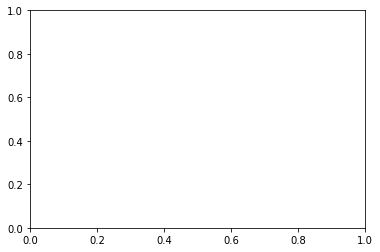

In [57]:
graphs_idx = [i for i in range(len(g_all))]
plt.bar(graphs_idx, subgraphs_maxxed)
plt.xlabel("Index of Donor Graph")
plt.ylabel("No. of subgraphs maximized")
plt.title("How many subgraphs does each donor maximize")
plt.show()

In [ ]:
gamma = []
beta = []
for i in range(len(g_list)):
    data = g_data[i]
    gamma.append(float(data[0]))
    beta.append(float(data[1]))
plt.scatter(gamma, beta, c= subgraphs_maxxed, vmin = 1, vmax = 55, marker = 'o')
clb = plt.colorbar()
clb.ax.set_ylabel('# of subgraphs with this as optima',fontsize=10)
plt.xlabel('gamma')
plt.ylabel('beta')
plt.title("Tranferability of Donor's Optima to subgraphs")
plt.show()